# Imports

In [54]:
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

#validation imports
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

#text feature extraction classes
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

#Type of Model to Train
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

#Matplotlib 
from matplotlib import pyplot as plt, gridspec
import seaborn as sns
#plt.rcdefaults()

# Data Exploration & Pre-process

In [50]:
#Fake or Real News set
fake_real = 'fake_or_real_news.csv'
    #regression model
    #gonna need to split

#Liar-Liar Pants on Fire set
liar_liar = ['train.tsv', 'test.tsv', 'valid.tsv']

In [51]:
#================================================================================
#############################
#1. real_fake news dataframe#
#############################
dffr = pd.read_csv(fake_real, sep=',', usecols = [2, 3])

#rename columns for clarity and set index, drop irrelevant columns
dffr.columns = ['claim', 'signal']

#rename signals to 'false' & 'true'
dffr['signal'] = np.where(dffr['signal'] == 'FAKE', 'false', 'true')

len(dffr)
dffr.tail()


#================================================================================
#############################
#2. "Liar" unified dataframe#
#############################

################################################################################
#"Liar" has been pre-separated into 3 sets for training, testing, & validation #
#These will be reunified and the kfold validation method will be used instead  #
################################################################################
dfll = pd.DataFrame()
for file in liar_liar:
    df = pd.read_table(file, sep="\t", header=None, usecols=[1, 2])
    
    #rename to match the other frame for later combination
    df.columns = ['signal', 'claim']
    dfll = dfll.append(df, ignore_index=True)

#drop duplicates, re-order  columns
dfll = dfll.drop_duplicates()
dfll = dfll[['claim', 'signal']]

##################################################################
#we will consider only 'true' and 'false' statements, while      #
#converting 'pants-fire' into 'false' & 'mostly-true' into 'true #
#'barely' & 'half' truths will be dropped due to their AMBIGUITY #
##################################################################

relabel ={'false':'false', 'true':'true',
          'mostly-true':'true','pants-fire':'false'}
dfll['signal'] = dfll['signal'].map(relabel)

#mapping produces NaN where the ambiguous labels were
#Note: >4000 NaN observations will be dropped
dfll = dfll.dropna(axis=0)
dfll = dfll.reset_index(drop=True)
len(dfll)
dfll.head()


#================================================================================
######################################
#3. Combined "Liar" & "FakeReal" sets#
######################################
dfrl = pd.concat([dffr, dfll], ignore_index=True)
len(dfrl)
dfrl[6331:6341]


6335

,claim,signal
6330,The State Department told the Republican Natio...,true
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,false
6332,Anti-Trump Protesters Are Tools of the Oligar...,false
6333,"ADDIS ABABA, Ethiopia —President Obama convene...",true
6334,Jeb Bush Is Suddenly Attacking Trump. Here's W...,true


8044

,claim,signal
0,Says the Annies List political group supports ...,false
1,"Hillary Clinton agrees with John McCain ""by vo...",true
2,Health care reform legislation is likely to ma...,false
3,The Chicago Bears have had more starting quart...,true
4,Says GOP primary opponents Glenn Grothman and ...,true


14379

,claim,signal
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,false
6332,Anti-Trump Protesters Are Tools of the Oligar...,false
6333,"ADDIS ABABA, Ethiopia —President Obama convene...",true
6334,Jeb Bush Is Suddenly Attacking Trump. Here's W...,true
6335,Says the Annies List political group supports ...,false
6336,"Hillary Clinton agrees with John McCain ""by vo...",true
6337,Health care reform legislation is likely to ma...,false
6338,The Chicago Bears have had more starting quart...,true
6339,Says GOP primary opponents Glenn Grothman and ...,true
6340,"For the first time in history, the share of th...",true


# Helper Functions

In [58]:
def get_scores(ground_val, predicted):
    """Returns relevant scores which will be used for graphing"""
    
    accuracy = metrics.accuracy_score(ground_val, predicted)
    recall = metrics.recall_score(ground_val, predicted, pos_label='true')
    precision = metrics.precision_score(ground_val, predicted, pos_label='true')
    f1_score = metrics.f1_score(ground_val, predicted,pos_label='true')
    
    return [accuracy, recall, precision, f1_score]



def update_vect_scores(scores_list):
    """Takes the index_wise average of the nested lists in scores_lists,
    and then updates the dictionary belonging to each "Configuration" """ 
    
    scores = [sum(e)/len(e) for e in zip(*scores_list)]
    
    performance_scores = {'Accuracy': "%0.3f" % scores[0], 
                         'Recall': "%0.3f" % scores[1] , 
                         'Precision': "%0.3f" % scores[2],
                         'F1_Score': "%0.3f" % scores[3]}

    return performance_scores

def plot_graph(tests, train, super_title): 
    """Takes in the two dictionaries with the average
    values corresponding to training and testing sets as
    well as the vectorizer used and plots them as bar graphs """
    
    #Fig + Subplots
    fig = plt.figure(figsize=(16,20))
    grid = gridspec.GridSpec(2,1)
    
    p1 = plt.subplot(grid[0,0])
    p2 = plt.subplot(grid[1,0])
    
    #fontsize
    fz = 25
    
    #DataFrame transformation of dictionaries
    df1 = pd.DataFrame.from_dict(tests, orient='index', dtype='float')
    df2 = pd.DataFrame.from_dict(train, orient='index', dtype='float')
    
    #Main Title
    plt.suptitle(super_title, fontsize=40)
    
    #Plots
    plot1 = df1.plot(kind='bar', ax=p1, fontsize=fz, rot=45)
    p1.set_title("Performance on Training Set", fontsize=fz)
    p1.set_ylabel("Performance", fontsize=fz)
    p1.legend(fontsize=fz, loc=4)
    
    plot2 = df2.plot(kind='bar', ax=p2, fontsize=fz, rot=45)
    p2.set_title("Performance on Testing Set", fontsize=fz)
    p2.set_ylabel("Performance", fontsize=fz)
    p2.legend(fontsize=fz, loc=4)
    
    #WhiteSpace
    fig.subplots_adjust(top=0.2)
    plt.tight_layout()
    
    plt.show()
    plt.close('all')

## Configuration 1
    Model A: train a model on 'FakeReal' set & test and validate using k-fold

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Training


,Accuracy,Recall,Precision,F1_Score
CountVzr,0.996,0.992,0.999,0.996
HashingVzr,0.995,0.991,0.999,0.995
TfidVzr,0.996,0.992,0.999,0.995


Testing


,Accuracy,Recall,Precision,F1_Score
CountVzr,0.845,0.819,0.864,0.841
HashingVzr,0.814,0.760,0.853,0.804
TfidVzr,0.837,0.801,0.863,0.831


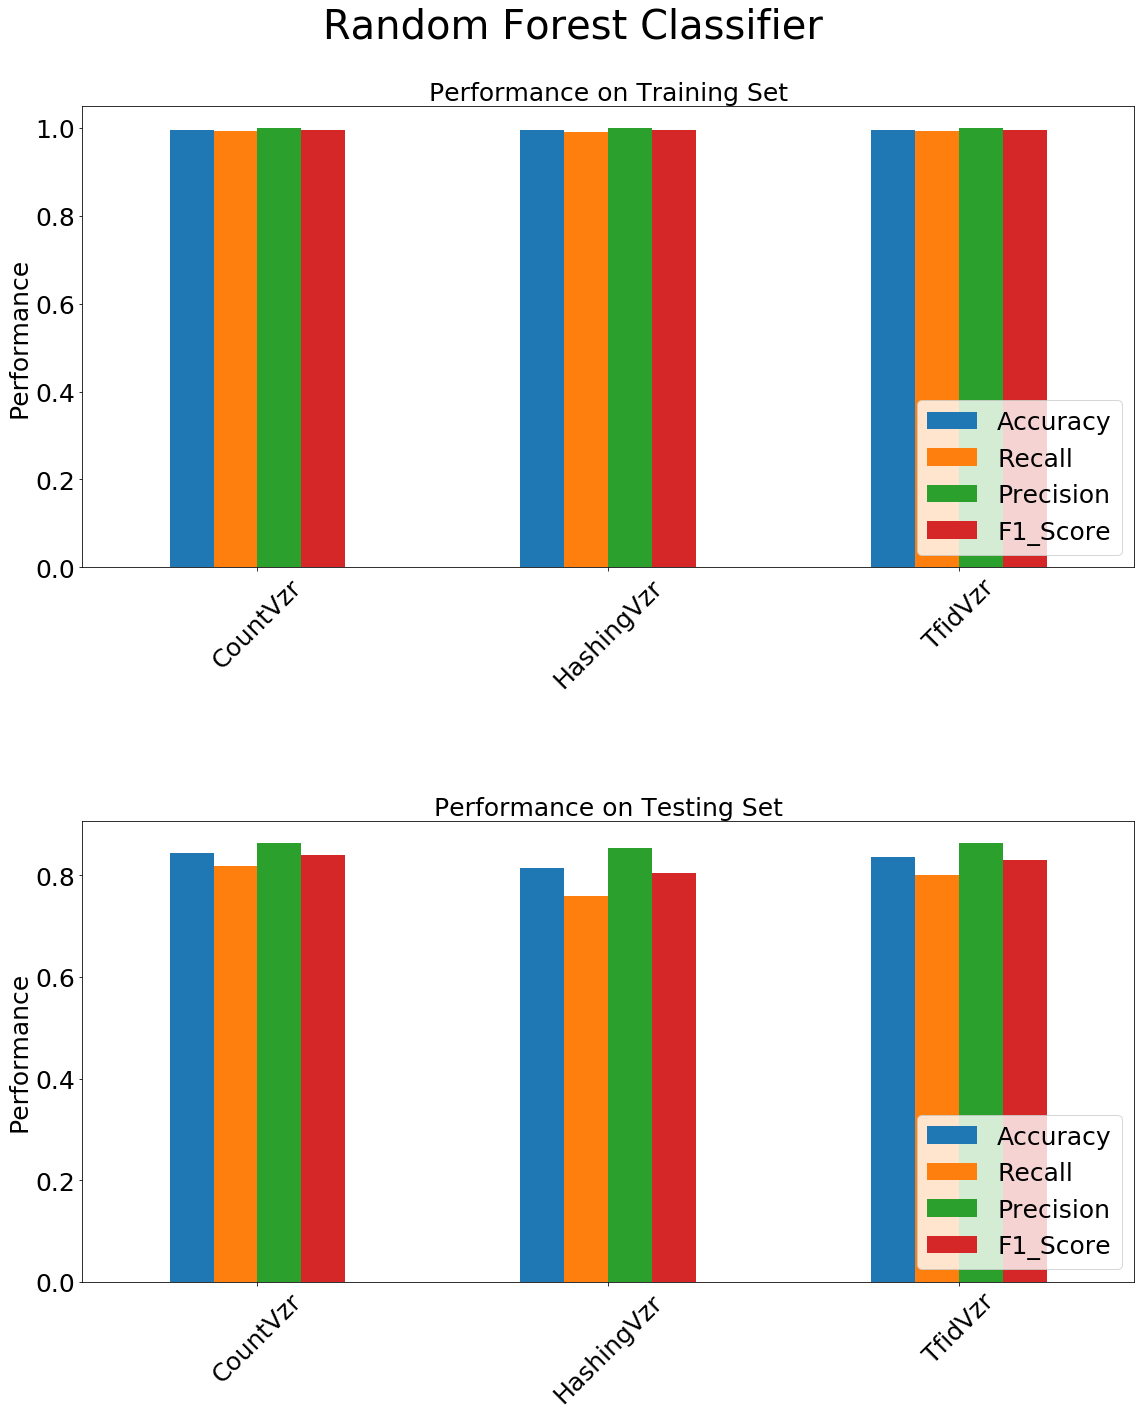

In [59]:
#this kfold object needs to be initialized only once
skf = StratifiedKFold(n_splits=5, shuffle= True,random_state = 4222)


#Feature extraction to loop through
vectorizers = [HashingVectorizer(stop_words='english'), 
               CountVectorizer(stop_words ='english', max_df=0.7),
               TfidfVectorizer(stop_words='english', max_df=0.7)]

#These dictionaries store the averaged values from
#each feature extraction class for later graphing
vzr_train = {"HashingVzr": {},
              "CountVzr": {},
              "TfidVzr": {}}

vzr_tests = {"HashingVzr": {},
              "CountVzr": {},
              "TfidVzr": {}}

#idx for updating the specifc feature extraction
#class scores after each full kfold iteration
idx = 0
for vzr in vectorizers:
    #to store and then average performance scores
    train_scores = []
    tests_scores = []
    

    for train_idx, tests_idx in skf.split(dffr['claim'], dffr['signal']):
    
        ######################
        ##Feature extraction##
        ######################
        vectorizer = vzr
        train = vectorizer.fit_transform(dffr['claim'][train_idx])
        tests = vectorizer.transform(dffr['claim'][tests_idx])

        #fitting & testing the model
        model = RandomForestClassifier()
        model.fit(train, dffr['signal'][train_idx])
        
        #testing fitted model
        predxn_tests = model.predict(tests)
        predxn_train = model.predict(train)


        #evaluation of models & storage of values
        tests_scores.append(get_scores(dffr['signal'][tests_idx], predxn_tests))
        train_scores.append(get_scores(dffr['signal'][train_idx], predxn_train))   

    #updates the dictionary of avereaged scores from each vectorizer class  
    vrizer = ["HashingVzr", "CountVzr", "TfidVzr"]
    #training set dictinary update
    vzr_train[vrizer[idx]].update(update_vect_scores(train_scores))
    #testing set dictionary update
    vzr_tests[vrizer[idx]].update(update_vect_scores(tests_scores)) 
    idx += 1


print("Training")
pd.DataFrame.from_dict(vzr_train, orient='index', dtype='float')
print("Testing")
pd.DataFrame.from_dict(vzr_tests, orient='index', dtype='float')

plot_graph(vzr_train, vzr_tests, "Random Forest Classifier")


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

Training


,Accuracy,Recall,Precision,F1_Score
CountVzr,0.885,0.859,0.908,0.882
HashingVzr,0.897,0.882,0.910,0.896
TfidVzr,0.899,0.884,0.911,0.897


Testing


,Accuracy,Recall,Precision,F1_Score
CountVzr,0.873,0.843,0.897,0.869
HashingVzr,0.872,0.857,0.884,0.870
TfidVzr,0.878,0.867,0.887,0.877


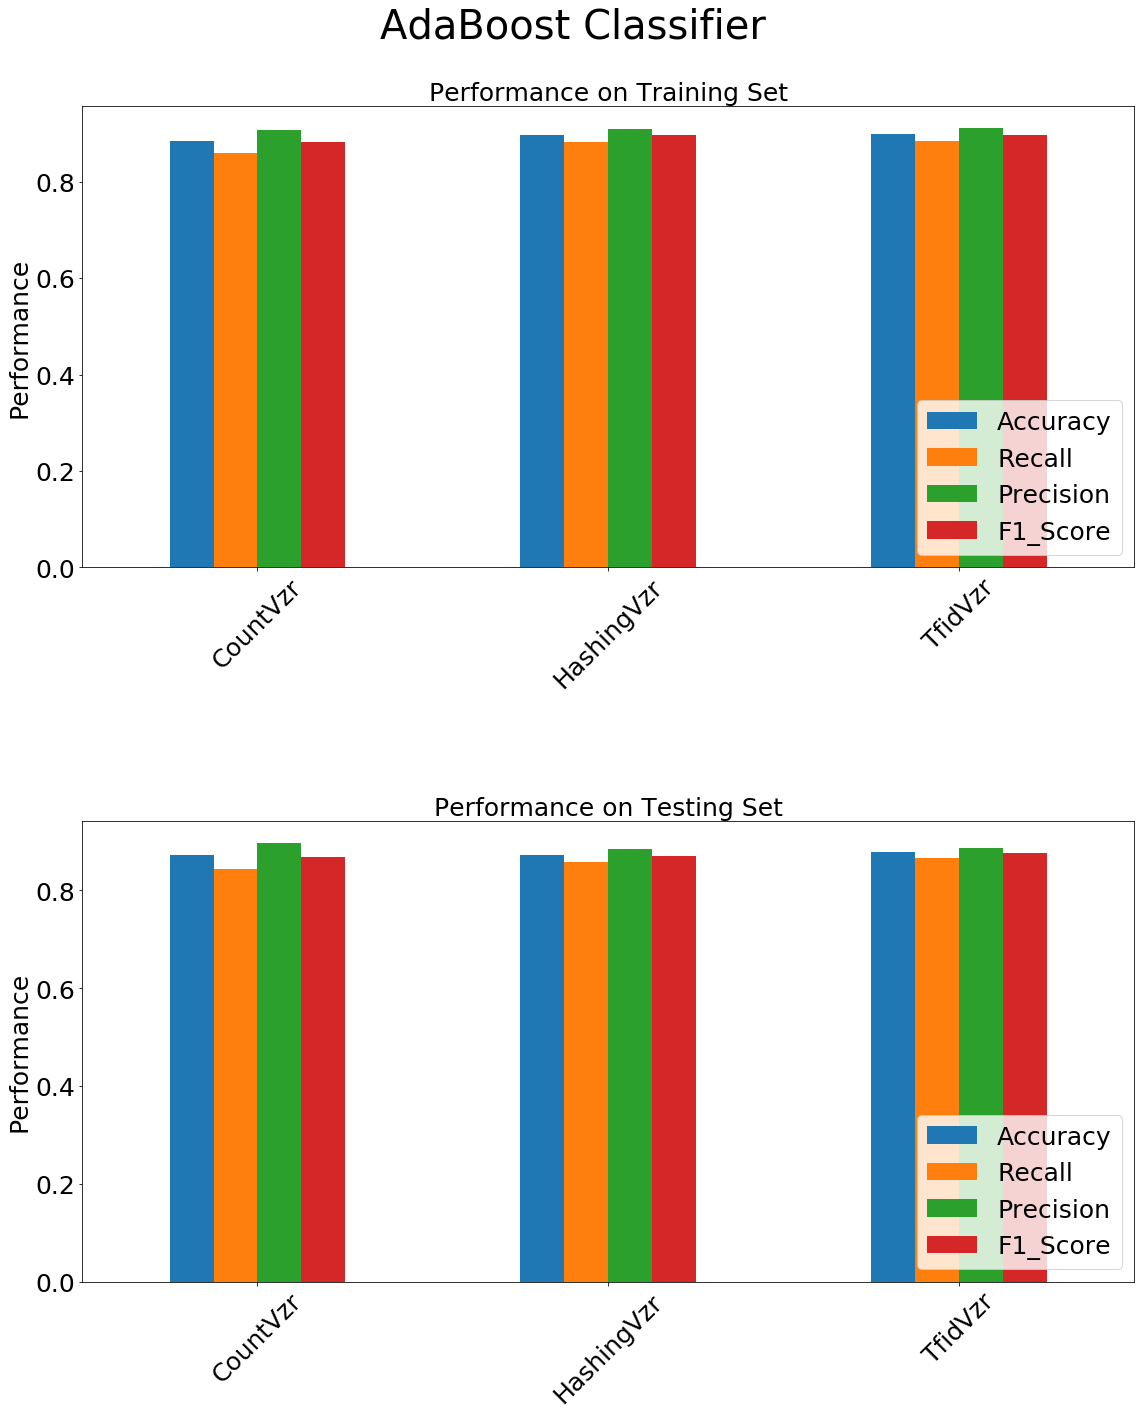

In [60]:
#Feature extraction to loop through
vectorizers = [HashingVectorizer(stop_words='english'), 
               CountVectorizer(stop_words ='english', max_df=0.7),
               TfidfVectorizer(stop_words='english', max_df=0.7)]

#These dictionaries store the averaged values from
#each feature extraction class for later graphing
vzr_train = {"HashingVzr": {},
              "CountVzr": {},
              "TfidVzr": {}}

vzr_tests = {"HashingVzr": {},
              "CountVzr": {},
              "TfidVzr": {}}

#idx for updating the specifc feature extraction
#class scores after each full kfold iteration
idx = 0
for vzr in vectorizers:
    #to store and then average performance scores
    train_scores = []
    tests_scores = []
    

    for train_idx, tests_idx in skf.split(dffr['claim'], dffr['signal']):
    
        ######################
        ##Feature extraction##
        ######################
        vectorizer = vzr
        train = vectorizer.fit_transform(dffr['claim'][train_idx])
        tests = vectorizer.transform(dffr['claim'][tests_idx])

        #fitting & testing the model
        model = AdaBoostClassifier()
        model.fit(train, dffr['signal'][train_idx])
        
        #testing fitted model
        predxn_tests = model.predict(tests)
        predxn_train = model.predict(train)


        #evaluation of models & storage of values
        tests_scores.append(get_scores(dffr['signal'][tests_idx], predxn_tests))
        train_scores.append(get_scores(dffr['signal'][train_idx], predxn_train))   

    #updates the dictionary of avereaged scores from each vectorizer class  
    vrizer = ["HashingVzr", "CountVzr", "TfidVzr"]
    #training set dictinary update
    vzr_train[vrizer[idx]].update(update_vect_scores(train_scores))
    #testing set dictionary update
    vzr_tests[vrizer[idx]].update(update_vect_scores(tests_scores)) 
    idx += 1

print("Training")
pd.DataFrame.from_dict(vzr_train, orient='index', dtype='float')
print("Testing")
pd.DataFrame.from_dict(vzr_tests, orient='index', dtype='float')

plot_graph(vzr_train, vzr_tests, "AdaBoost Classifier")


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Training


,Accuracy,Recall,Precision,F1_Score
CountVzr,1.000,0.999,1.000,1.000
HashingVzr,0.944,0.937,0.951,0.944
TfidVzr,0.958,0.945,0.969,0.957


Testing


,Accuracy,Recall,Precision,F1_Score
CountVzr,0.919,0.907,0.931,0.918
HashingVzr,0.911,0.898,0.923,0.910
TfidVzr,0.918,0.892,0.941,0.916


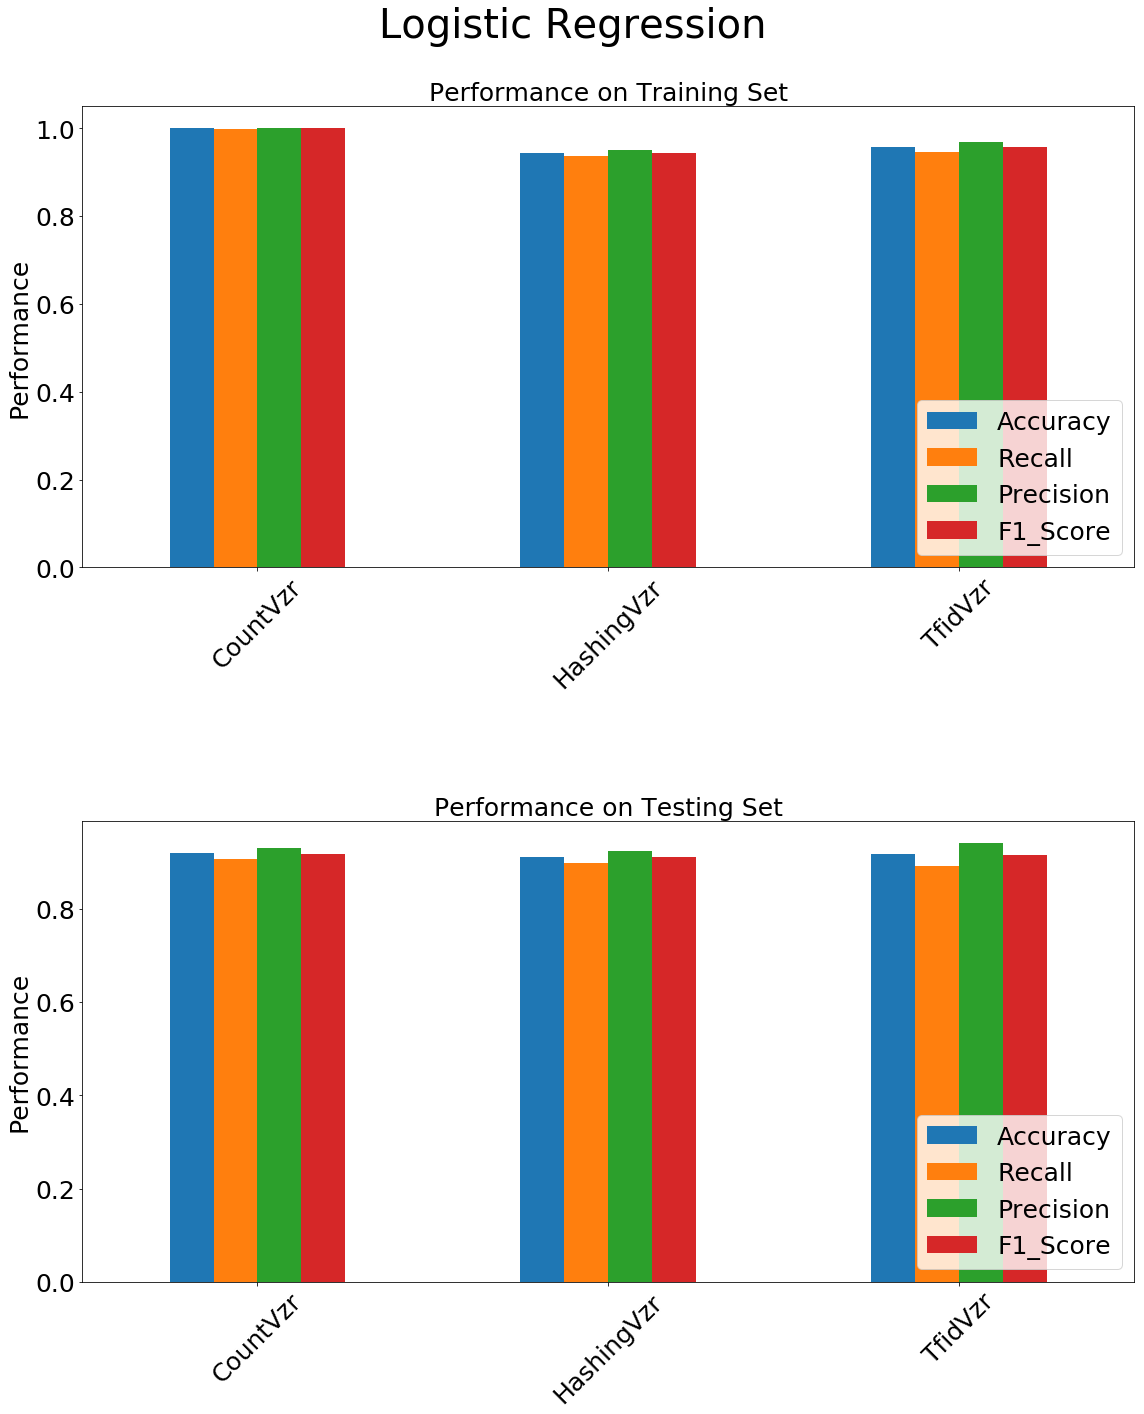

In [61]:
#Feature extraction to loop through
vectorizers = [HashingVectorizer(stop_words='english'), 
               CountVectorizer(stop_words ='english', max_df=0.7),
               TfidfVectorizer(stop_words='english', max_df=0.7)]

#These dictionaries store the averaged values from
#each feature extraction class for later graphing
vzr_train = {"HashingVzr": {},
              "CountVzr": {},
              "TfidVzr": {}}

vzr_tests = {"HashingVzr": {},
              "CountVzr": {},
              "TfidVzr": {}}

#idx for updating the specifc feature extraction
#class scores after each full kfold iteration
idx = 0
for vzr in vectorizers:
    #to store and then average performance scores
    train_scores = []
    tests_scores = []
    

    for train_idx, tests_idx in skf.split(dffr['claim'], dffr['signal']):
    
        ######################
        ##Feature extraction##
        ######################
        vectorizer = vzr
        train = vectorizer.fit_transform(dffr['claim'][train_idx])
        tests = vectorizer.transform(dffr['claim'][tests_idx])

        #fitting & testing the model
        model = LogisticRegression()
        model.fit(train, dffr['signal'][train_idx])
        
        #testing fitted model
        predxn_tests = model.predict(tests)
        predxn_train = model.predict(train)


        #evaluation of models & storage of values
        tests_scores.append(get_scores(dffr['signal'][tests_idx], predxn_tests))
        train_scores.append(get_scores(dffr['signal'][train_idx], predxn_train))   

    #updates the dictionary of avereaged scores from each vectorizer class  
    vrizer = ["HashingVzr", "CountVzr", "TfidVzr"]
    #training set dictinary update
    vzr_train[vrizer[idx]].update(update_vect_scores(train_scores))
    #testing set dictionary update
    vzr_tests[vrizer[idx]].update(update_vect_scores(tests_scores)) 
    idx += 1

print("Training")
pd.DataFrame.from_dict(vzr_train, orient='index', dtype='float')

print("Testing")
pd.DataFrame.from_dict(vzr_tests, orient='index', dtype='float')
plot_graph(vzr_train, vzr_tests, "Logistic Regression")

## Configuration 2
    Model B: train a model on 'Liar' set & test and validate using k-fold

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Training


,Accuracy,Recall,Precision,F1_Score
CountVzr,0.986,0.984,0.992,0.988
HashingVzr,0.989,0.986,0.994,0.990
TfidVzr,0.985,0.984,0.990,0.987


Testing


,Accuracy,Recall,Precision,F1_Score
CountVzr,0.608,0.639,0.653,0.646
HashingVzr,0.596,0.617,0.645,0.631
TfidVzr,0.607,0.654,0.647,0.650


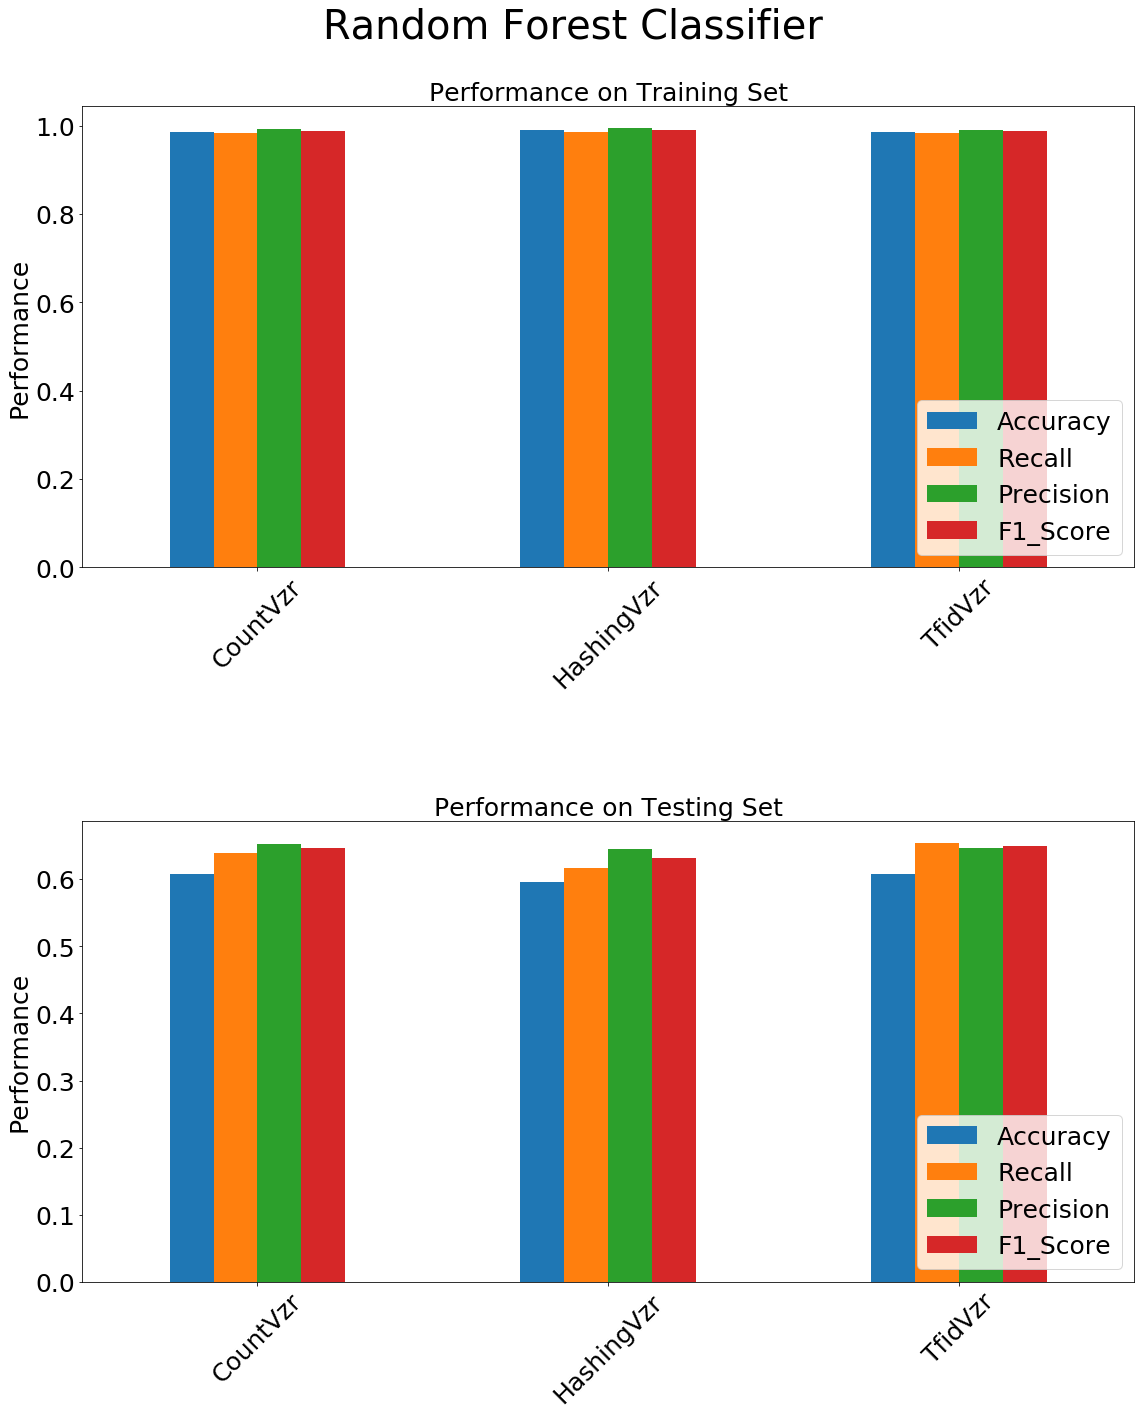

In [62]:
#Feature extraction to loop through
vectorizers = [HashingVectorizer(stop_words='english'), 
               CountVectorizer(stop_words ='english', max_df=0.7),
               TfidfVectorizer(stop_words='english', max_df=0.7)]

#These dictionaries store the averaged values from
#each feature extraction class for later graphing
vzr_train = {"HashingVzr": {},
              "CountVzr": {},
              "TfidVzr": {}}

vzr_tests = {"HashingVzr": {},
              "CountVzr": {},
              "TfidVzr": {}}

#idx for updating the specifc feature extraction
#class scores after each full kfold iteration
idx = 0
for vzr in vectorizers:
    #to store and then average performance scores
    train_scores = []
    tests_scores = []
    

    for train_idx, tests_idx in skf.split(dfll['claim'], dfll['signal']):
    
        ######################
        ##Feature extraction##
        ######################
        vectorizer = vzr
        train = vectorizer.fit_transform(dfll['claim'][train_idx])
        tests = vectorizer.transform(dfll['claim'][tests_idx])

        #fitting & testing the model
        model = RandomForestClassifier()
        model.fit(train, dfll['signal'][train_idx])
        
        #testing fitted model
        predxn_tests = model.predict(tests)
        predxn_train = model.predict(train)


        #evaluation of models & storage of values
        tests_scores.append(get_scores(dfll['signal'][tests_idx], predxn_tests))
        train_scores.append(get_scores(dfll['signal'][train_idx], predxn_train))   

    #updates the dictionary of avereaged scores from each vectorizer class  
    vrizer = ["HashingVzr", "CountVzr", "TfidVzr"]
    #training set dictinary update
    vzr_train[vrizer[idx]].update(update_vect_scores(train_scores))
    #testing set dictionary update
    vzr_tests[vrizer[idx]].update(update_vect_scores(tests_scores)) 
    idx += 1

print("Training")
pd.DataFrame.from_dict(vzr_train, orient='index', dtype='float')
print("Testing")
pd.DataFrame.from_dict(vzr_tests, orient='index', dtype='float')

plot_graph(vzr_train, vzr_tests, "Random Forest Classifier")

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

Training


,Accuracy,Recall,Precision,F1_Score
CountVzr,0.631,0.862,0.624,0.723
HashingVzr,0.636,0.868,0.627,0.727
TfidVzr,0.638,0.856,0.630,0.725


Testing


,Accuracy,Recall,Precision,F1_Score
CountVzr,0.605,0.843,0.606,0.705
HashingVzr,0.602,0.843,0.604,0.703
TfidVzr,0.604,0.821,0.608,0.699


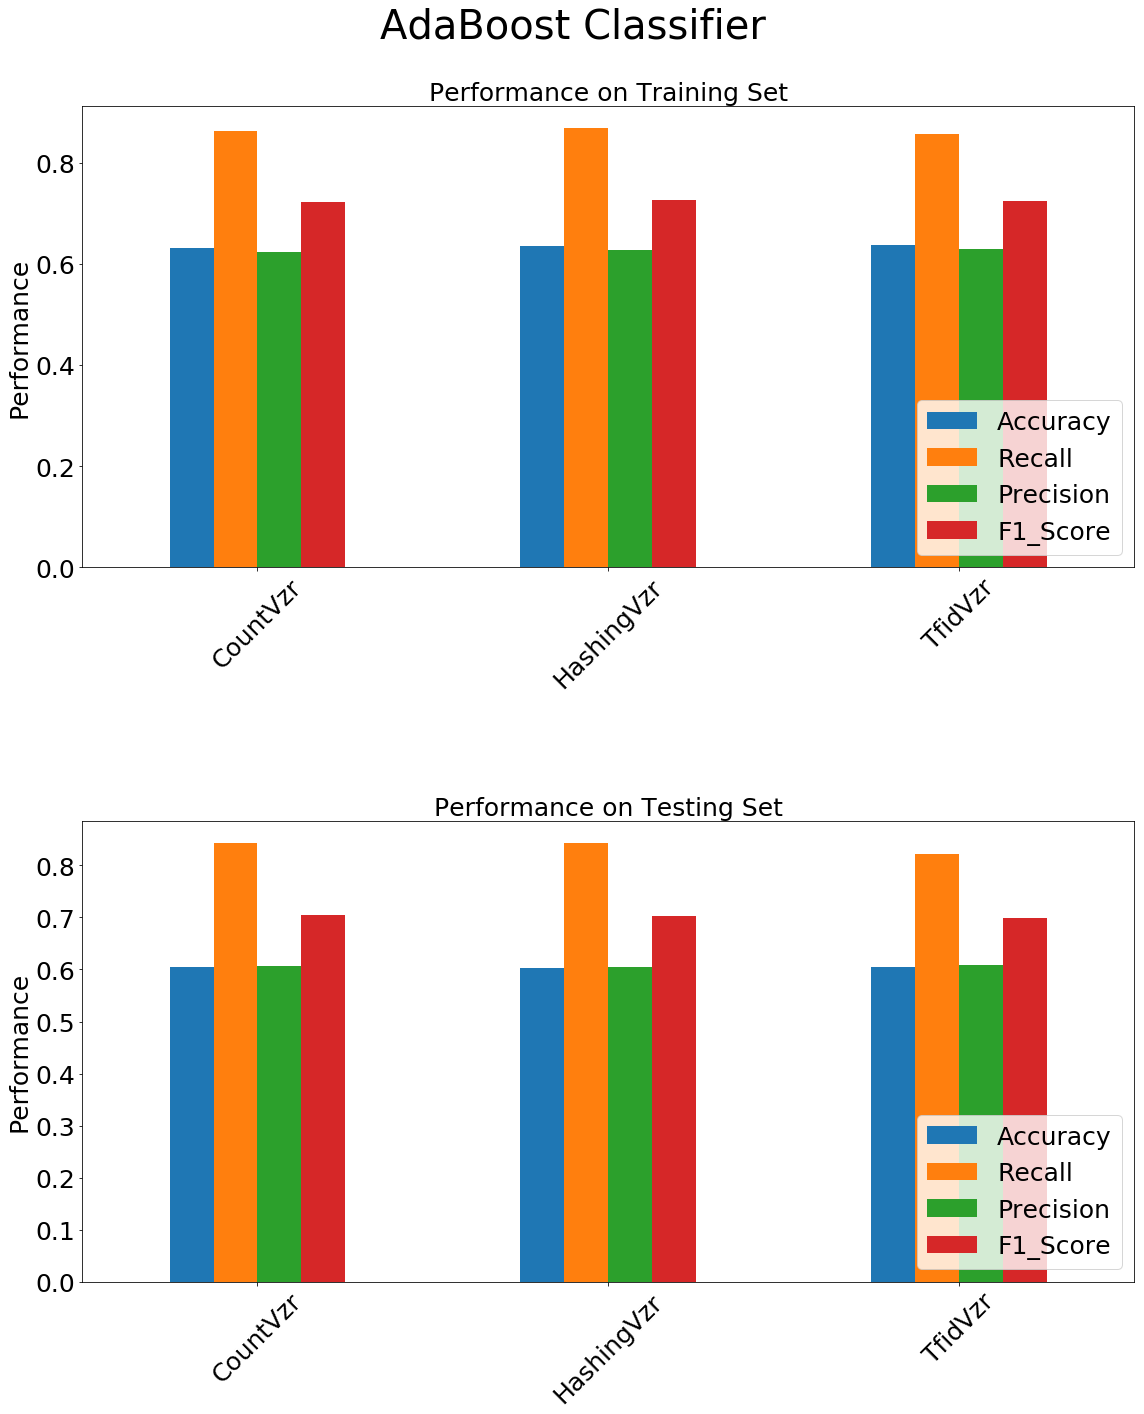

In [63]:
#Feature extraction to loop through
vectorizers = [HashingVectorizer(stop_words='english'), 
               CountVectorizer(stop_words ='english', max_df=0.7),
               TfidfVectorizer(stop_words='english', max_df=0.7)]

#These dictionaries store the averaged values from
#each feature extraction class for later graphing
vzr_train = {"HashingVzr": {},
              "CountVzr": {},
              "TfidVzr": {}}

vzr_tests = {"HashingVzr": {},
              "CountVzr": {},
              "TfidVzr": {}}

#idx for updating the specifc feature extraction
#class scores after each full kfold iteration
idx = 0
for vzr in vectorizers:
    #to store and then average performance scores
    train_scores = []
    tests_scores = []
    

    for train_idx, tests_idx in skf.split(dfll['claim'], dfll['signal']):
    
        ######################
        ##Feature extraction##
        ######################
        vectorizer = vzr
        train = vectorizer.fit_transform(dfll['claim'][train_idx])
        tests = vectorizer.transform(dfll['claim'][tests_idx])

        #fitting & testing the model
        model = AdaBoostClassifier()
        model.fit(train, dfll['signal'][train_idx])
        
        #testing fitted model
        predxn_tests = model.predict(tests)
        predxn_train = model.predict(train)


        #evaluation of models & storage of values
        tests_scores.append(get_scores(dfll['signal'][tests_idx], predxn_tests))
        train_scores.append(get_scores(dfll['signal'][train_idx], predxn_train))   

    #updates the dictionary of avereaged scores from each vectorizer class  
    vrizer = ["HashingVzr", "CountVzr", "TfidVzr"]
    #training set dictinary update
    vzr_train[vrizer[idx]].update(update_vect_scores(train_scores))
    #testing set dictionary update
    vzr_tests[vrizer[idx]].update(update_vect_scores(tests_scores)) 
    idx += 1

print("Training")
pd.DataFrame.from_dict(vzr_train, orient='index', dtype='float')
print("Testing")
pd.DataFrame.from_dict(vzr_tests, orient='index', dtype='float')

plot_graph(vzr_train, vzr_tests, "AdaBoost Classifier")

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Training


,Accuracy,Recall,Precision,F1_Score
CountVzr,0.917,0.949,0.906,0.927
HashingVzr,0.793,0.881,0.778,0.826
TfidVzr,0.830,0.916,0.806,0.858


Testing


,Accuracy,Recall,Precision,F1_Score
CountVzr,0.622,0.696,0.652,0.673
HashingVzr,0.640,0.765,0.653,0.704
TfidVzr,0.642,0.774,0.652,0.708


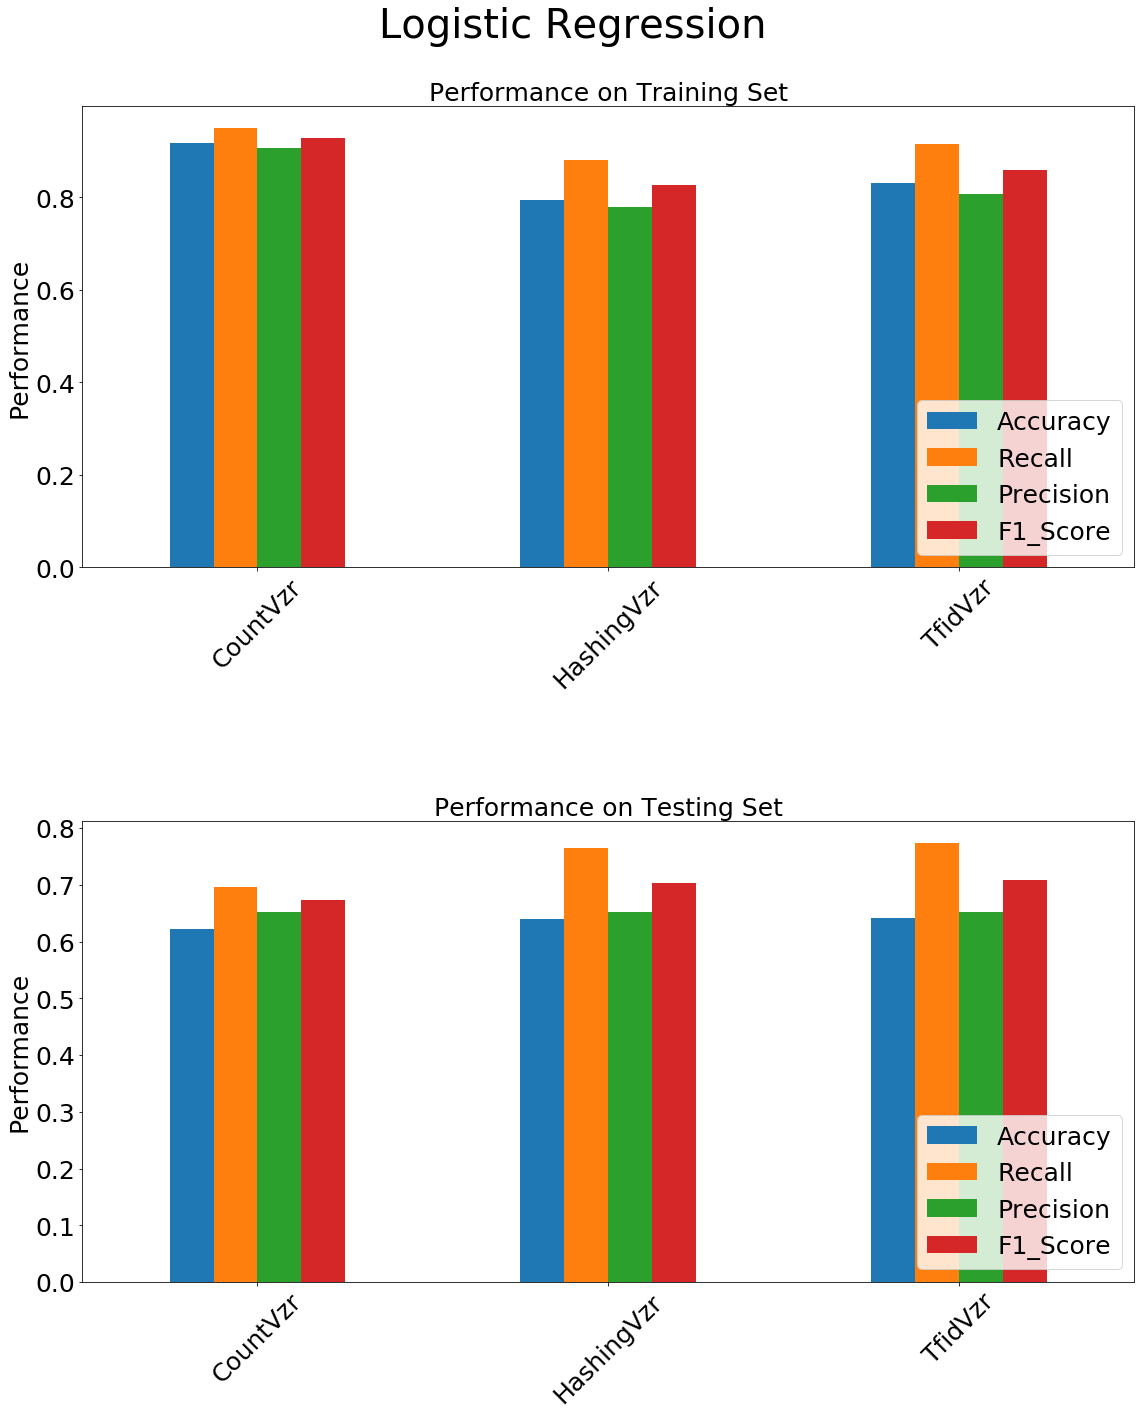

In [64]:
#Feature extraction to loop through
vectorizers = [HashingVectorizer(stop_words='english'), 
               CountVectorizer(stop_words ='english', max_df=0.7),
               TfidfVectorizer(stop_words='english', max_df=0.7)]

#These dictionaries store the averaged values from
#each feature extraction class for later graphing
vzr_train = {"HashingVzr": {},
              "CountVzr": {},
              "TfidVzr": {}}

vzr_tests = {"HashingVzr": {},
              "CountVzr": {},
              "TfidVzr": {}}

#idx for updating the specifc feature extraction
#class scores after each full kfold iteration
idx = 0
for vzr in vectorizers:
    #to store and then average performance scores
    train_scores = []
    tests_scores = []
    

    for train_idx, tests_idx in skf.split(dfll['claim'], dfll['signal']):
    
        ######################
        ##Feature extraction##
        ######################
        vectorizer = vzr
        train = vectorizer.fit_transform(dfll['claim'][train_idx])
        tests = vectorizer.transform(dfll['claim'][tests_idx])

        #fitting & testing the model
        model = LogisticRegression()
        model.fit(train, dfll['signal'][train_idx])
        
        #testing fitted model
        predxn_tests = model.predict(tests)
        predxn_train = model.predict(train)


        #evaluation of models & storage of values
        tests_scores.append(get_scores(dfll['signal'][tests_idx], predxn_tests))
        train_scores.append(get_scores(dfll['signal'][train_idx], predxn_train))   

    #updates the dictionary of avereaged scores from each vectorizer class  
    vrizer = ["HashingVzr", "CountVzr", "TfidVzr"]
    #training set dictinary update
    vzr_train[vrizer[idx]].update(update_vect_scores(train_scores))
    #testing set dictionary update
    vzr_tests[vrizer[idx]].update(update_vect_scores(tests_scores)) 
    idx += 1

print("Training")
pd.DataFrame.from_dict(vzr_train, orient='index', dtype='float')
print("Testing")
pd.DataFrame.from_dict(vzr_tests, orient='index', dtype='float')

plot_graph(vzr_train, vzr_tests, "Logistic Regression")

## Configuration 3.1
    Run a trained model on the set it was NOT trained on

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Training


,Accuracy,Recall,Precision,F1_Score
CountVzr,0.996,0.993,0.999,0.996
HashingVzr,0.995,0.991,0.999,0.995
TfidVzr,0.996,0.994,0.997,0.996


Testing


,Accuracy,Recall,Precision,F1_Score
CountVzr,0.440,0.035,0.502,0.065
HashingVzr,0.444,0.029,0.567,0.055
TfidVzr,0.449,0.073,0.557,0.129


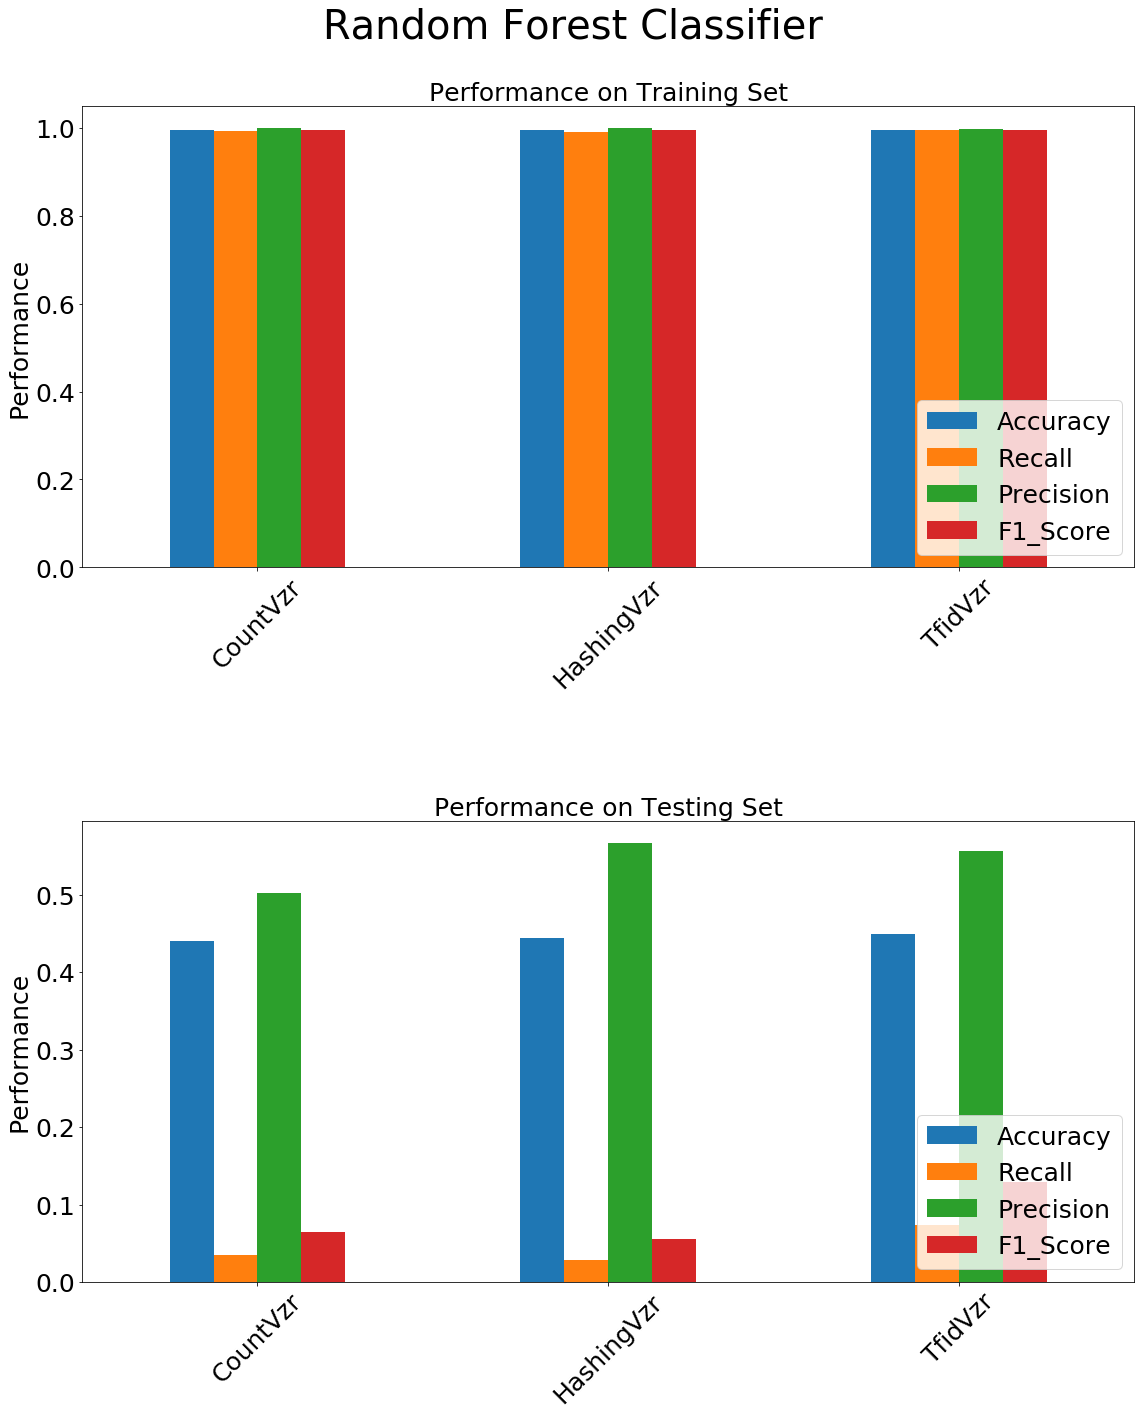

In [73]:
#Feature extraction to loop through
vectorizers = [HashingVectorizer(stop_words='english'), 
               CountVectorizer(stop_words ='english', max_df=0.7),
               TfidfVectorizer(stop_words='english', max_df=0.7)]

#These dictionaries store the averaged values from
#each feature extraction class for later graphing
vzr_train = {"HashingVzr": {},
              "CountVzr": {},
              "TfidVzr": {}}

vzr_tests = {"HashingVzr": {},
              "CountVzr": {},
              "TfidVzr": {}}

#idx for updating the specifc feature extraction
#class scores after each full kfold iteration
idx = 0
for vzr in vectorizers:
    #to store and then average performance scores
    train_scores = []
    tests_scores = []
    
    ########################################################
    #####Feature extraction
    vectorizer = vzr

    ##### Train on Real/Fake ####
    train = vectorizer.fit_transform(dffr['claim'])
    ##### Test on Liar-Liar #####
    tests = vectorizer.transform(dfll['claim'])
    
    ##### fitting & testing the model
    model = RandomForestClassifier()    
    model.fit(train, dffr['signal'])

    ##### testing fitted model
    predxn_tests = model.predict(tests)
    predxn_train = model.predict(train)
    ########################################################

    #evaluation of models & storage of values
    tests_scores.append(get_scores(dfll['signal'], predxn_tests))
    train_scores.append(get_scores(dffr['signal'], predxn_train))   
    
    
    #updates the dictionary of avereaged scores from each vectorizer class  
    vrizer = ["HashingVzr", "CountVzr", "TfidVzr"]
    #training set dictinary update
    vzr_train[vrizer[idx]].update(update_vect_scores(train_scores))
    #testing set dictionary update
    vzr_tests[vrizer[idx]].update(update_vect_scores(tests_scores)) 
    idx += 1

print("Training")
pd.DataFrame.from_dict(vzr_train, orient='index', dtype='float')
print("Testing")
pd.DataFrame.from_dict(vzr_tests, orient='index', dtype='float')

plot_graph(vzr_train, vzr_tests, "Random Forest Classifier")

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

Training


,Accuracy,Recall,Precision,F1_Score
CountVzr,0.887,0.863,0.907,0.885
HashingVzr,0.895,0.887,0.902,0.894
TfidVzr,0.900,0.889,0.910,0.899


Testing


,Accuracy,Recall,Precision,F1_Score
CountVzr,0.439,0.114,0.497,0.185
HashingVzr,0.475,0.406,0.542,0.464
TfidVzr,0.474,0.395,0.541,0.457


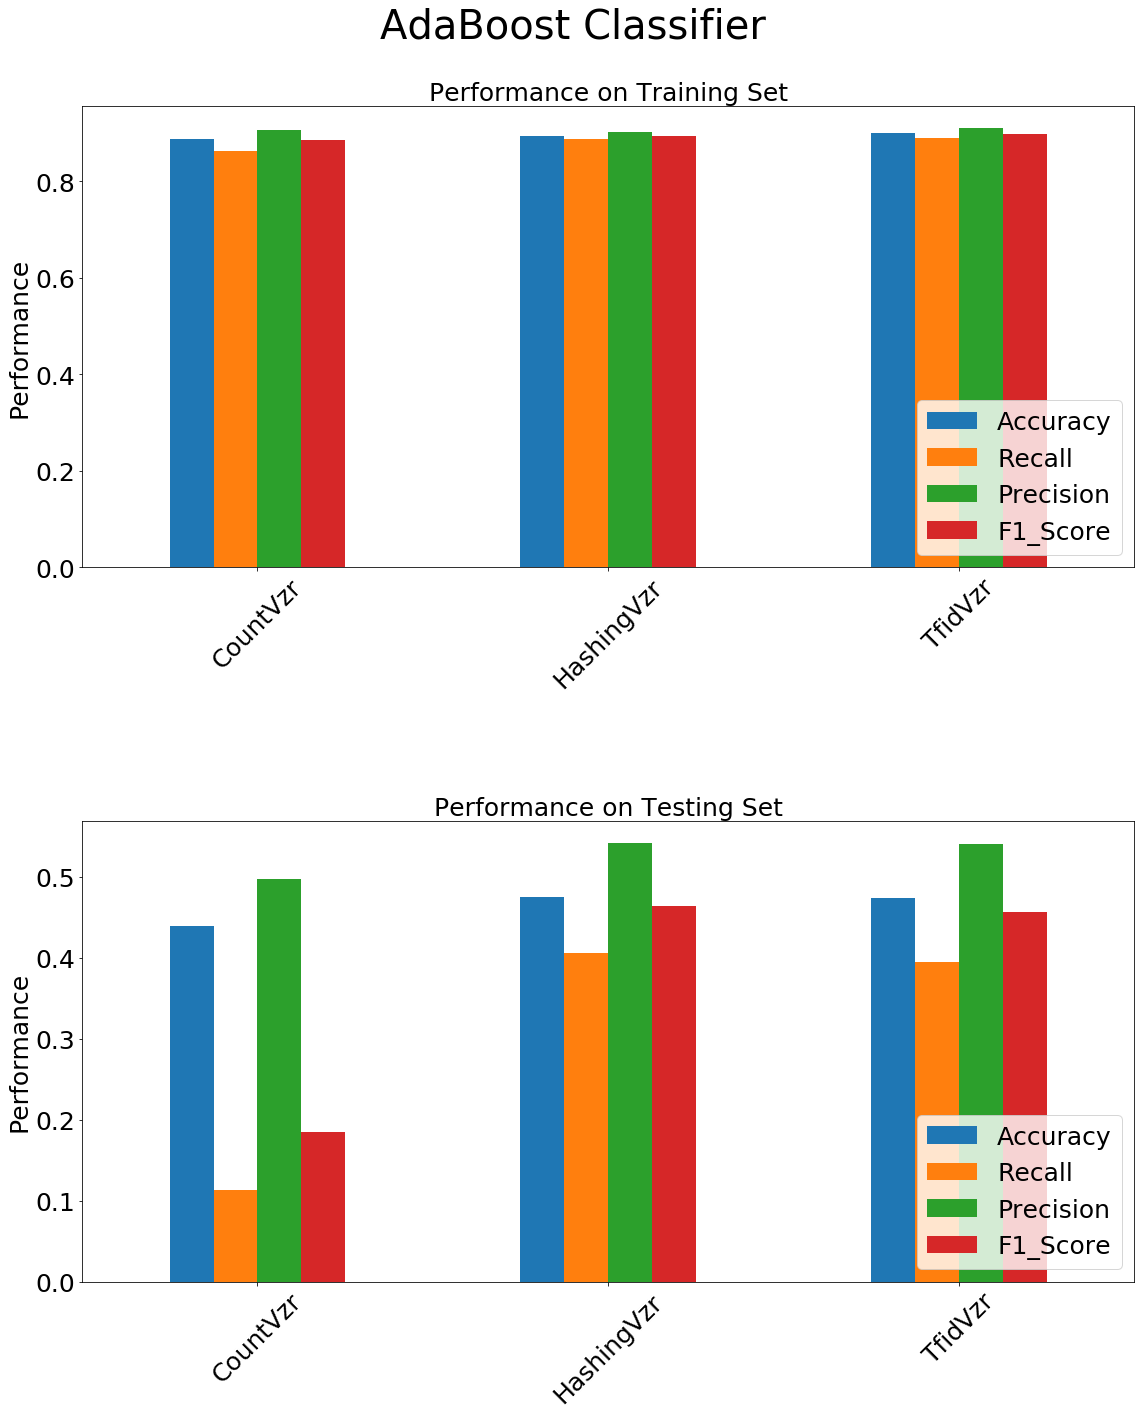

In [74]:
#Feature extraction to loop through
vectorizers = [HashingVectorizer(stop_words='english'), 
               CountVectorizer(stop_words ='english', max_df=0.7),
               TfidfVectorizer(stop_words='english', max_df=0.7)]

#These dictionaries store the averaged values from
#each feature extraction class for later graphing
vzr_train = {"HashingVzr": {},
              "CountVzr": {},
              "TfidVzr": {}}

vzr_tests = {"HashingVzr": {},
              "CountVzr": {},
              "TfidVzr": {}}

#idx for updating the specifc feature extraction
#class scores after each full kfold iteration
idx = 0
for vzr in vectorizers:
    #to store and then average performance scores
    train_scores = []
    tests_scores = []
    
    ########################################################
    #####Feature extraction
    vectorizer = vzr

    ##### Train on Real/Fake ####
    train = vectorizer.fit_transform(dffr['claim'])
    ##### Test on Liar-Liar #####
    tests = vectorizer.transform(dfll['claim'])
    
    ##### fitting & testing the model
    model = AdaBoostClassifier()
    model.fit(train, dffr['signal'])

    ##### testing fitted model
    predxn_tests = model.predict(tests)
    predxn_train = model.predict(train)
    ########################################################

    #evaluation of models & storage of values
    tests_scores.append(get_scores(dfll['signal'], predxn_tests))
    train_scores.append(get_scores(dffr['signal'], predxn_train))   
    
    
    #updates the dictionary of avereaged scores from each vectorizer class  
    vrizer = ["HashingVzr", "CountVzr", "TfidVzr"]
    #training set dictinary update
    vzr_train[vrizer[idx]].update(update_vect_scores(train_scores))
    #testing set dictionary update
    vzr_tests[vrizer[idx]].update(update_vect_scores(tests_scores)) 
    idx += 1

print("Training")
pd.DataFrame.from_dict(vzr_train, orient='index', dtype='float')
print("Testing")
pd.DataFrame.from_dict(vzr_tests, orient='index', dtype='float')

plot_graph(vzr_train, vzr_tests, "AdaBoost Classifier")

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Training


,Accuracy,Recall,Precision,F1_Score
CountVzr,1.000,0.999,1.00,1.000
HashingVzr,0.945,0.940,0.95,0.945
TfidVzr,0.958,0.947,0.97,0.958


Testing


,Accuracy,Recall,Precision,F1_Score
CountVzr,0.441,0.111,0.501,0.182
HashingVzr,0.458,0.243,0.536,0.334
TfidVzr,0.459,0.167,0.556,0.256


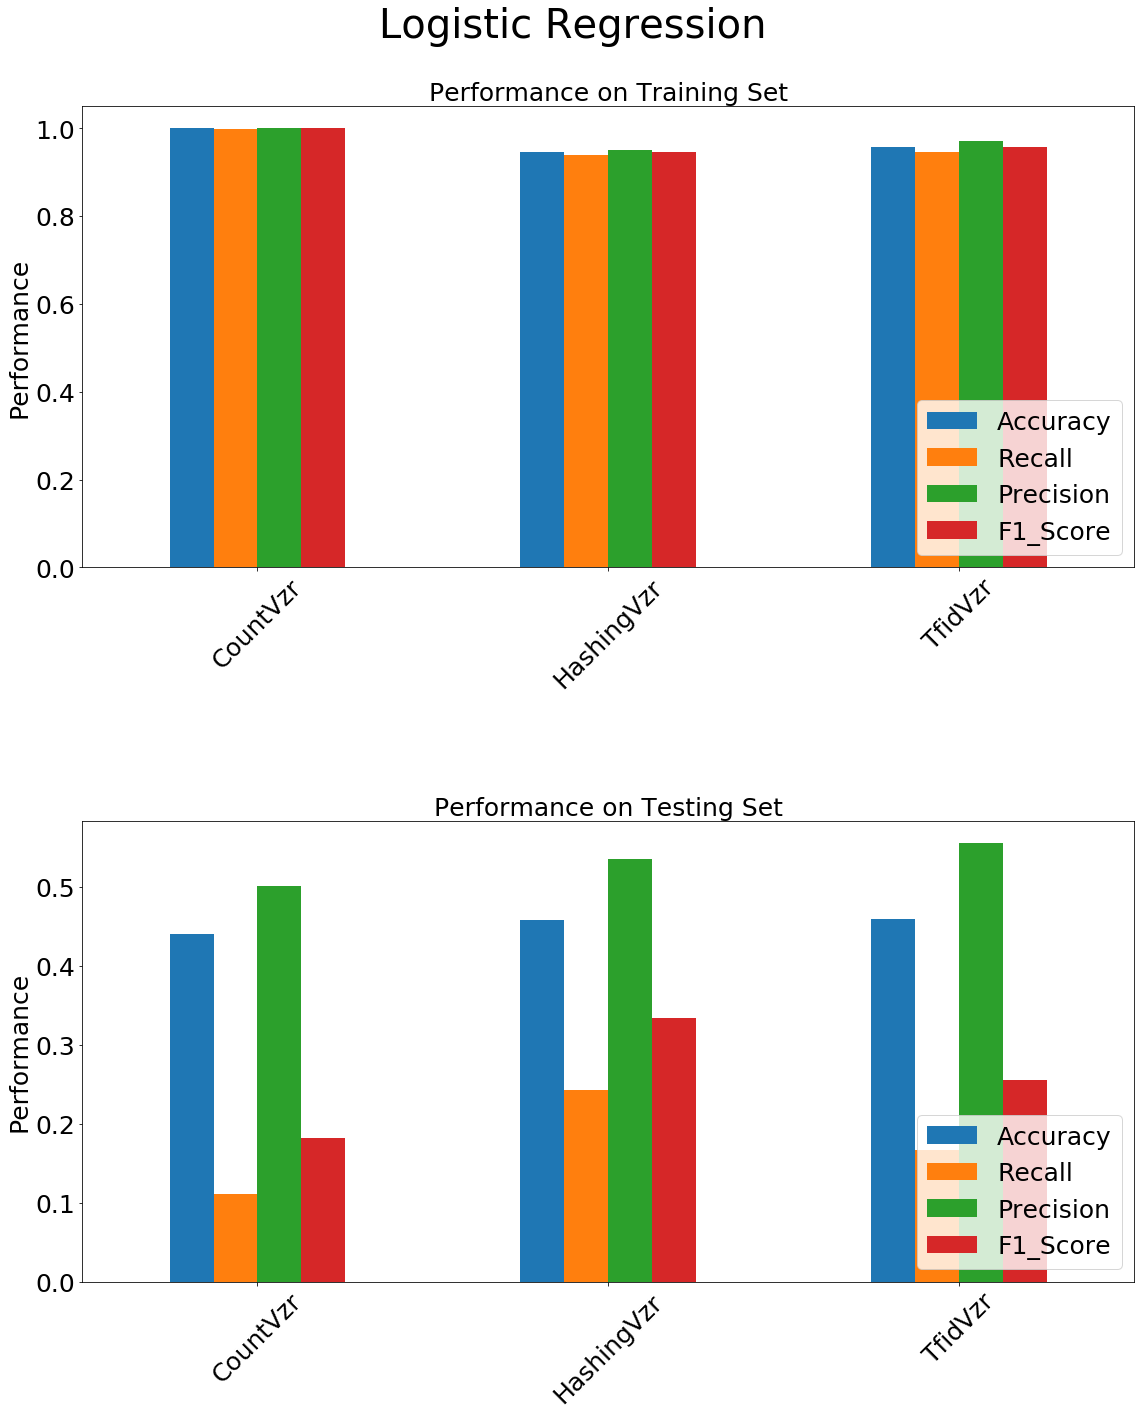

In [77]:
#Feature extraction to loop through
vectorizers = [HashingVectorizer(stop_words='english'), 
               CountVectorizer(stop_words ='english', max_df=0.7),
               TfidfVectorizer(stop_words='english', max_df=0.7)]

#These dictionaries store the averaged values from
#each feature extraction class for later graphing
vzr_train = {"HashingVzr": {},
              "CountVzr": {},
              "TfidVzr": {}}

vzr_tests = {"HashingVzr": {},
              "CountVzr": {},
              "TfidVzr": {}}

#idx for updating the specifc feature extraction
#class scores after each full kfold iteration
idx = 0
for vzr in vectorizers:
    #to store and then average performance scores
    train_scores = []
    tests_scores = []
    
    ########################################################
    #####Feature extraction
    vectorizer = vzr

    ##### Train on Real/Fake ####
    train = vectorizer.fit_transform(dffr['claim'])
    ##### Test on Liar-Liar #####
    tests = vectorizer.transform(dfll['claim'])
    
    ##### fitting & testing the model
    model = LogisticRegression()
    model.fit(train, dffr['signal'])

    ##### testing fitted model
    predxn_tests = model.predict(tests)
    predxn_train = model.predict(train)
    ########################################################

    #evaluation of models & storage of values
    tests_scores.append(get_scores(dfll['signal'], predxn_tests))
    train_scores.append(get_scores(dffr['signal'], predxn_train))   
    
    
    #updates the dictionary of avereaged scores from each vectorizer class  
    vrizer = ["HashingVzr", "CountVzr", "TfidVzr"]
    #training set dictinary update
    vzr_train[vrizer[idx]].update(update_vect_scores(train_scores))
    #testing set dictionary update
    vzr_tests[vrizer[idx]].update(update_vect_scores(tests_scores)) 
    idx += 1

print("Training")
pd.DataFrame.from_dict(vzr_train, orient='index', dtype='float')
print("Testing")
pd.DataFrame.from_dict(vzr_tests, orient='index', dtype='float')

plot_graph(vzr_train, vzr_tests, "Logistic Regression")

## Configuration 3.2
    Run a trained model on the set it was NOT trained on

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Training


,Accuracy,Recall,Precision,F1_Score
CountVzr,0.986,0.984,0.991,0.987
HashingVzr,0.987,0.982,0.994,0.988
TfidVzr,0.987,0.986,0.990,0.988


Testing


,Accuracy,Recall,Precision,F1_Score
CountVzr,0.479,0.318,0.470,0.379
HashingVzr,0.502,0.382,0.504,0.434
TfidVzr,0.469,0.546,0.474,0.507


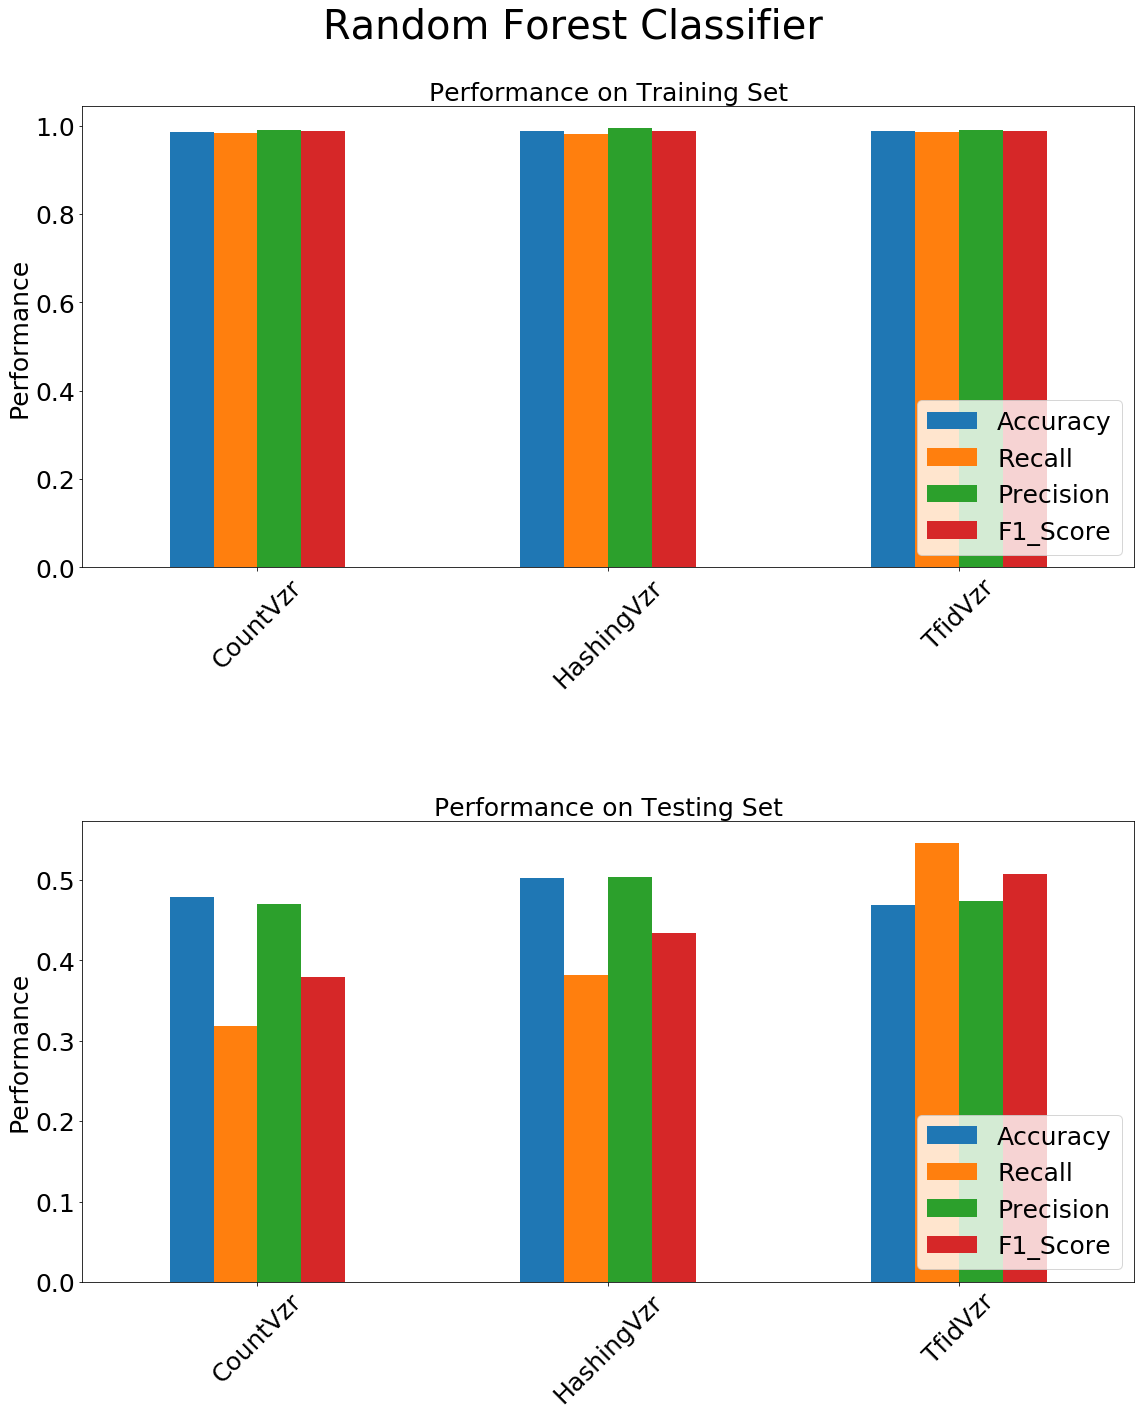

In [78]:
#Feature extraction to loop through
vectorizers = [HashingVectorizer(stop_words='english'), 
               CountVectorizer(stop_words ='english', max_df=0.7),
               TfidfVectorizer(stop_words='english', max_df=0.7)]

#These dictionaries store the averaged values from
#each feature extraction class for later graphing
vzr_train = {"HashingVzr": {},
              "CountVzr": {},
              "TfidVzr": {}}

vzr_tests = {"HashingVzr": {},
              "CountVzr": {},
              "TfidVzr": {}}

#idx for updating the specifc feature extraction
#class scores after each full kfold iteration
idx = 0
for vzr in vectorizers:
    #to store and then average performance scores
    train_scores = []
    tests_scores = []
    
    ########################################################
    #####Feature extraction
    vectorizer = vzr

    ##### Train on Liar-Liar ####
    train = vectorizer.fit_transform(dfll['claim'])
    ##### Test on Fake/Real #####
    tests = vectorizer.transform(dffr['claim'])
    
    ##### fitting & testing the model
    model = RandomForestClassifier()
    model.fit(train, dfll['signal'])

    ##### testing fitted model
    predxn_tests = model.predict(tests)
    predxn_train = model.predict(train)
    ########################################################

    #evaluation of models & storage of values
    tests_scores.append(get_scores(dffr['signal'], predxn_tests))
    train_scores.append(get_scores(dfll['signal'], predxn_train))   
    
    
    #updates the dictionary of avereaged scores from each vectorizer class  
    vrizer = ["HashingVzr", "CountVzr", "TfidVzr"]
    #training set dictinary update
    vzr_train[vrizer[idx]].update(update_vect_scores(train_scores))
    #testing set dictionary update
    vzr_tests[vrizer[idx]].update(update_vect_scores(tests_scores)) 
    idx += 1

print("Training")
pd.DataFrame.from_dict(vzr_train, orient='index', dtype='float')
print("Testing")
pd.DataFrame.from_dict(vzr_tests, orient='index', dtype='float')

plot_graph(vzr_train, vzr_tests, "Random Forest Classifier")

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

Training


,Accuracy,Recall,Precision,F1_Score
CountVzr,0.630,0.889,0.618,0.729
HashingVzr,0.631,0.813,0.633,0.711
TfidVzr,0.635,0.821,0.634,0.716


Testing


,Accuracy,Recall,Precision,F1_Score
CountVzr,0.472,0.682,0.481,0.564
HashingVzr,0.467,0.882,0.482,0.624
TfidVzr,0.474,0.903,0.486,0.632


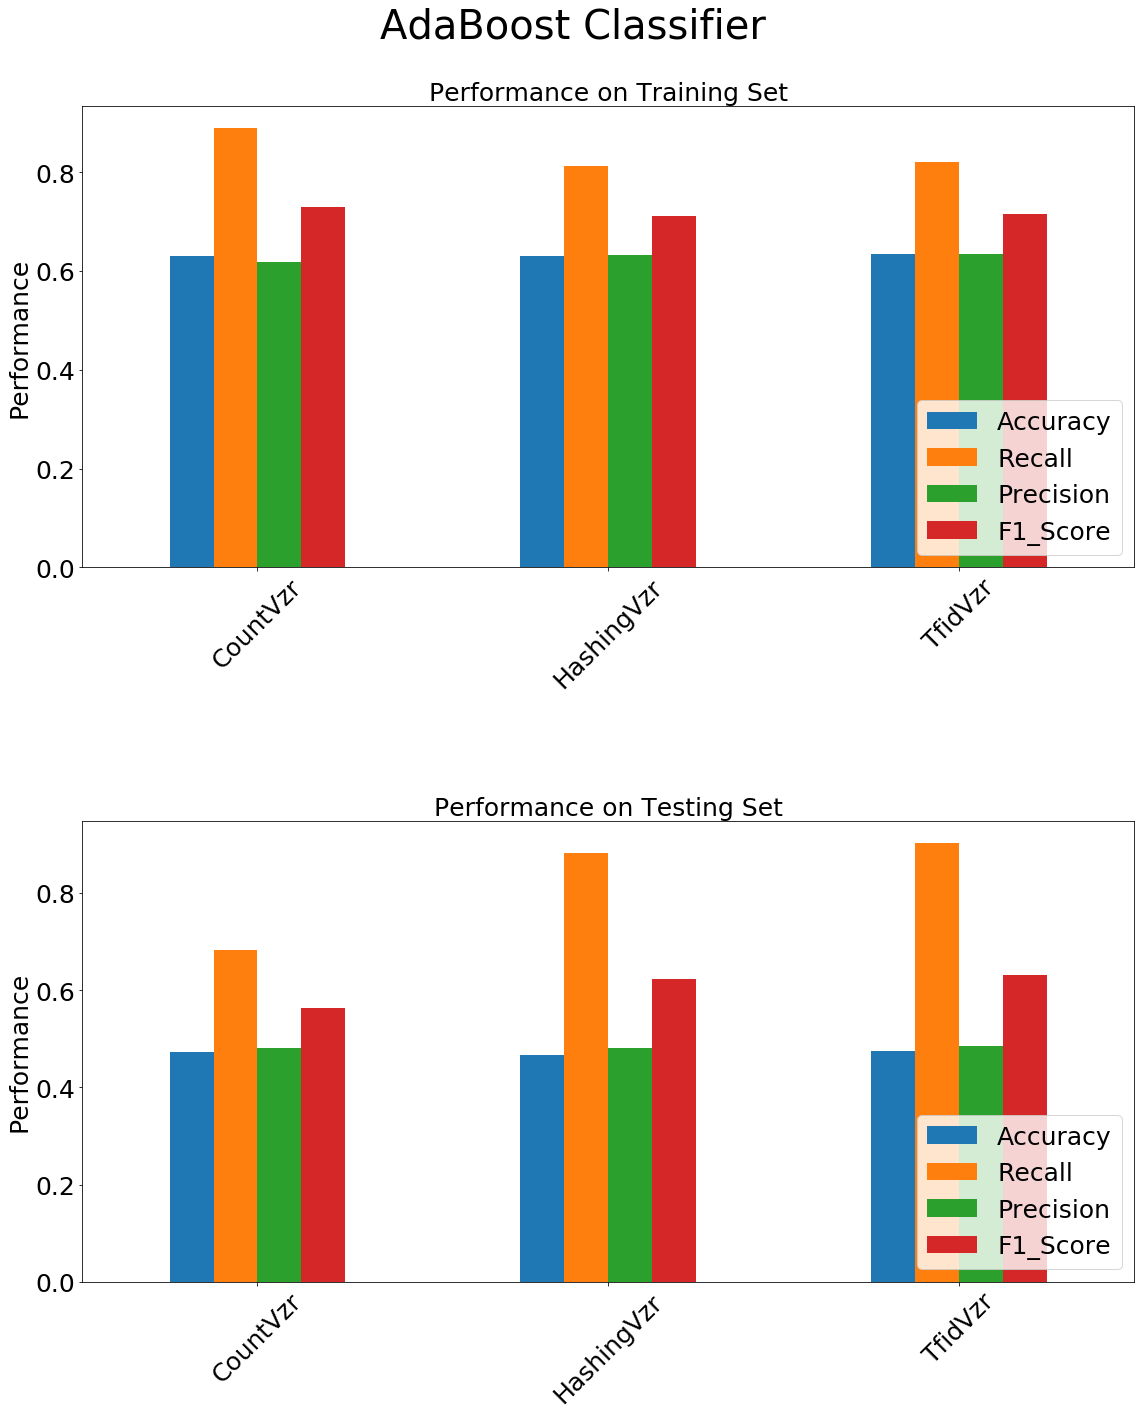

In [79]:
#Feature extraction to loop through
vectorizers = [HashingVectorizer(stop_words='english'), 
               CountVectorizer(stop_words ='english', max_df=0.7),
               TfidfVectorizer(stop_words='english', max_df=0.7)]

#These dictionaries store the averaged values from
#each feature extraction class for later graphing
vzr_train = {"HashingVzr": {},
              "CountVzr": {},
              "TfidVzr": {}}

vzr_tests = {"HashingVzr": {},
              "CountVzr": {},
              "TfidVzr": {}}

#idx for updating the specifc feature extraction
#class scores after each full kfold iteration
idx = 0
for vzr in vectorizers:
    #to store and then average performance scores
    train_scores = []
    tests_scores = []
    
    ########################################################
    #####Feature extraction
    vectorizer = vzr

    ##### Train on Liar-Liar ####
    train = vectorizer.fit_transform(dfll['claim'])
    ##### Test on Fake/Real #####
    tests = vectorizer.transform(dffr['claim'])
    
    ##### fitting & testing the model
    model = AdaBoostClassifier()
    model.fit(train, dfll['signal'])

    ##### testing fitted model
    predxn_tests = model.predict(tests)
    predxn_train = model.predict(train)
    ########################################################

    #evaluation of models & storage of values
    tests_scores.append(get_scores(dffr['signal'], predxn_tests))
    train_scores.append(get_scores(dfll['signal'], predxn_train))   
    
    
    #updates the dictionary of avereaged scores from each vectorizer class  
    vrizer = ["HashingVzr", "CountVzr", "TfidVzr"]
    #training set dictinary update
    vzr_train[vrizer[idx]].update(update_vect_scores(train_scores))
    #testing set dictionary update
    vzr_tests[vrizer[idx]].update(update_vect_scores(tests_scores)) 
    idx += 1

print("Training")
pd.DataFrame.from_dict(vzr_train, orient='index', dtype='float')
print("Testing")
pd.DataFrame.from_dict(vzr_tests, orient='index', dtype='float')

plot_graph(vzr_train, vzr_tests, "AdaBoost Classifier")

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Training


,Accuracy,Recall,Precision,F1_Score
CountVzr,0.905,0.939,0.896,0.917
HashingVzr,0.783,0.872,0.771,0.818
TfidVzr,0.819,0.902,0.800,0.848


Testing


,Accuracy,Recall,Precision,F1_Score
CountVzr,0.582,0.763,0.560,0.646
HashingVzr,0.534,0.722,0.525,0.608
TfidVzr,0.543,0.724,0.532,0.613


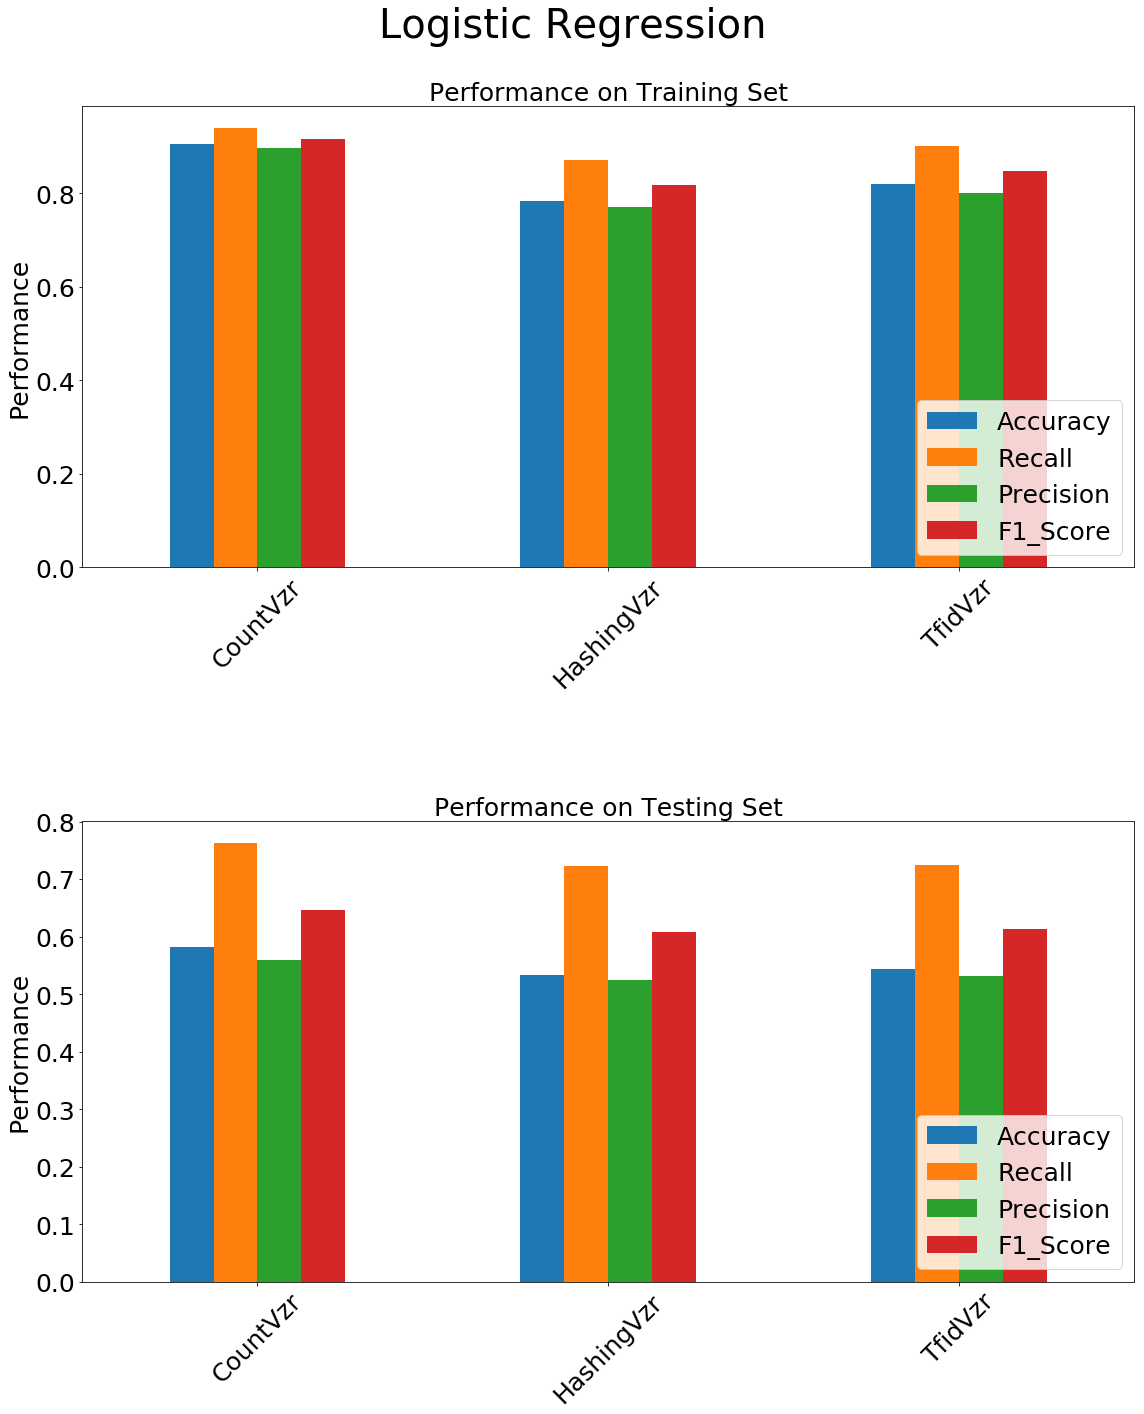

In [80]:
#Feature extraction to loop through
vectorizers = [HashingVectorizer(stop_words='english'), 
               CountVectorizer(stop_words ='english', max_df=0.7),
               TfidfVectorizer(stop_words='english', max_df=0.7)]

#These dictionaries store the averaged values from
#each feature extraction class for later graphing
vzr_train = {"HashingVzr": {},
              "CountVzr": {},
              "TfidVzr": {}}

vzr_tests = {"HashingVzr": {},
              "CountVzr": {},
              "TfidVzr": {}}

#idx for updating the specifc feature extraction
#class scores after each full kfold iteration
idx = 0
for vzr in vectorizers:
    #to store and then average performance scores
    train_scores = []
    tests_scores = []
    
    ########################################################
    #####Feature extraction
    vectorizer = vzr

    ##### Train on Liar-Liar ####
    train = vectorizer.fit_transform(dfll['claim'])
    ##### Test on Fake/Real #####
    tests = vectorizer.transform(dffr['claim'])
    
    ##### fitting & testing the model
    model = LogisticRegression()
    model.fit(train, dfll['signal'])

    ##### testing fitted model
    predxn_tests = model.predict(tests)
    predxn_train = model.predict(train)
    ########################################################

    #evaluation of models & storage of values
    tests_scores.append(get_scores(dffr['signal'], predxn_tests))
    train_scores.append(get_scores(dfll['signal'], predxn_train))   
    
    
    #updates the dictionary of avereaged scores from each vectorizer class  
    vrizer = ["HashingVzr", "CountVzr", "TfidVzr"]
    #training set dictinary update
    vzr_train[vrizer[idx]].update(update_vect_scores(train_scores))
    #testing set dictionary update
    vzr_tests[vrizer[idx]].update(update_vect_scores(tests_scores)) 
    idx += 1

print("Training")
pd.DataFrame.from_dict(vzr_train, orient='index', dtype='float')
print("Testing")
pd.DataFrame.from_dict(vzr_tests, orient='index', dtype='float')

plot_graph(vzr_train, vzr_tests, "Logistic Regression")

## Configuration 4
    Model C: train a model on the 'Combined' set & test and validate using k-fold

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Training


,Accuracy,Recall,Precision,F1_Score
CountVzr,0.990,0.985,0.996,0.991
HashingVzr,0.991,0.986,0.996,0.991
TfidVzr,0.989,0.984,0.996,0.990


Testing


,Accuracy,Recall,Precision,F1_Score
CountVzr,0.702,0.663,0.750,0.704
HashingVzr,0.676,0.637,0.723,0.677
TfidVzr,0.705,0.670,0.750,0.708


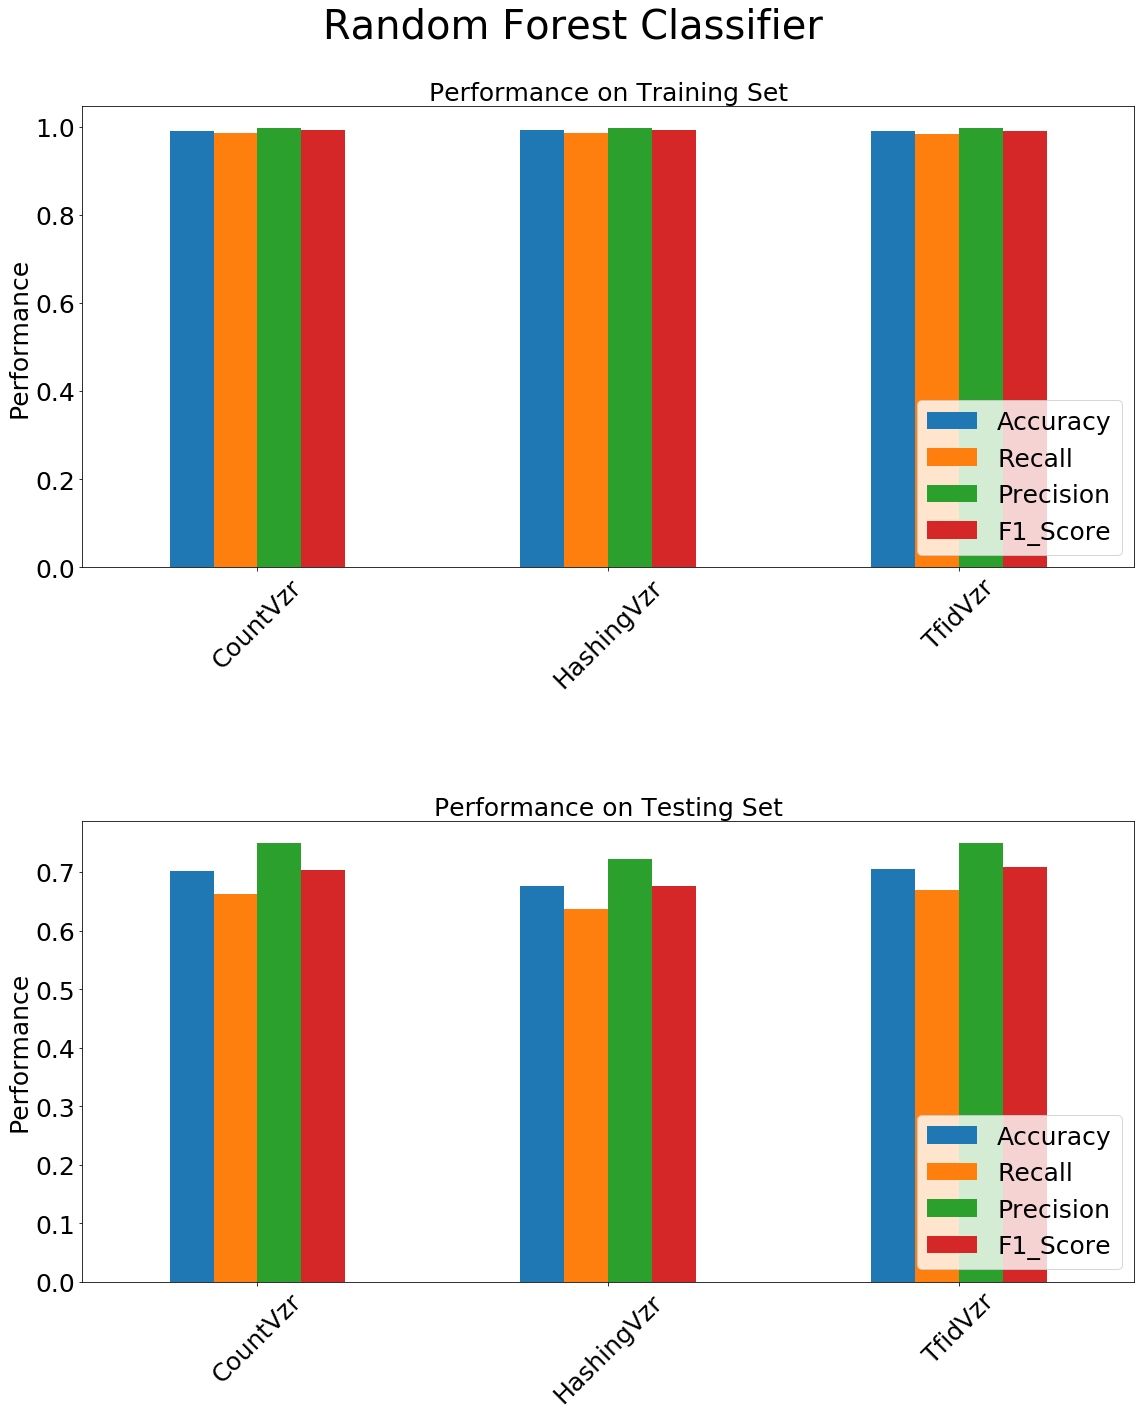

In [81]:
#Feature extraction to loop through
vectorizers = [HashingVectorizer(stop_words='english'), 
               CountVectorizer(stop_words ='english', max_df=0.7),
               TfidfVectorizer(stop_words='english', max_df=0.7)]

#These dictionaries store the averaged values from
#each feature extraction class for later graphing
vzr_train = {"HashingVzr": {},
              "CountVzr": {},
              "TfidVzr": {}}

vzr_tests = {"HashingVzr": {},
              "CountVzr": {},
              "TfidVzr": {}}

#idx for updating the specifc feature extraction
#class scores after each full kfold iteration
idx = 0
for vzr in vectorizers:
    #to store and then average performance scores
    train_scores = []
    tests_scores = []
    

    for train_idx, tests_idx in skf.split(dfrl['claim'], dfrl['signal']):
    
        ######################
        ##Feature extraction##
        ######################
        vectorizer = vzr
        train = vectorizer.fit_transform(dfrl['claim'][train_idx])
        tests = vectorizer.transform(dfrl['claim'][tests_idx])

        #fitting & testing the model
        model = RandomForestClassifier()
        model.fit(train, dfrl['signal'][train_idx])
        
        #testing fitted model
        predxn_tests = model.predict(tests)
        predxn_train = model.predict(train)


        #evaluation of models & storage of values
        tests_scores.append(get_scores(dfrl['signal'][tests_idx], predxn_tests))
        train_scores.append(get_scores(dfrl['signal'][train_idx], predxn_train))   

    #updates the dictionary of avereaged scores from each vectorizer class  
    vrizer = ["HashingVzr", "CountVzr", "TfidVzr"]
    #training set dictinary update
    vzr_train[vrizer[idx]].update(update_vect_scores(train_scores))
    #testing set dictionary update
    vzr_tests[vrizer[idx]].update(update_vect_scores(tests_scores)) 
    idx += 1

print("Training")
pd.DataFrame.from_dict(vzr_train, orient='index', dtype='float')
print("Testing")
pd.DataFrame.from_dict(vzr_tests, orient='index', dtype='float')

plot_graph(vzr_train, vzr_tests, "Random Forest Classifier")

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

Training


,Accuracy,Recall,Precision,F1_Score
CountVzr,0.697,0.954,0.647,0.771
HashingVzr,0.694,0.775,0.716,0.718
TfidVzr,0.689,0.619,0.777,0.672


Testing


,Accuracy,Recall,Precision,F1_Score
CountVzr,0.690,0.950,0.641,0.766
HashingVzr,0.675,0.762,0.695,0.703
TfidVzr,0.670,0.603,0.749,0.652


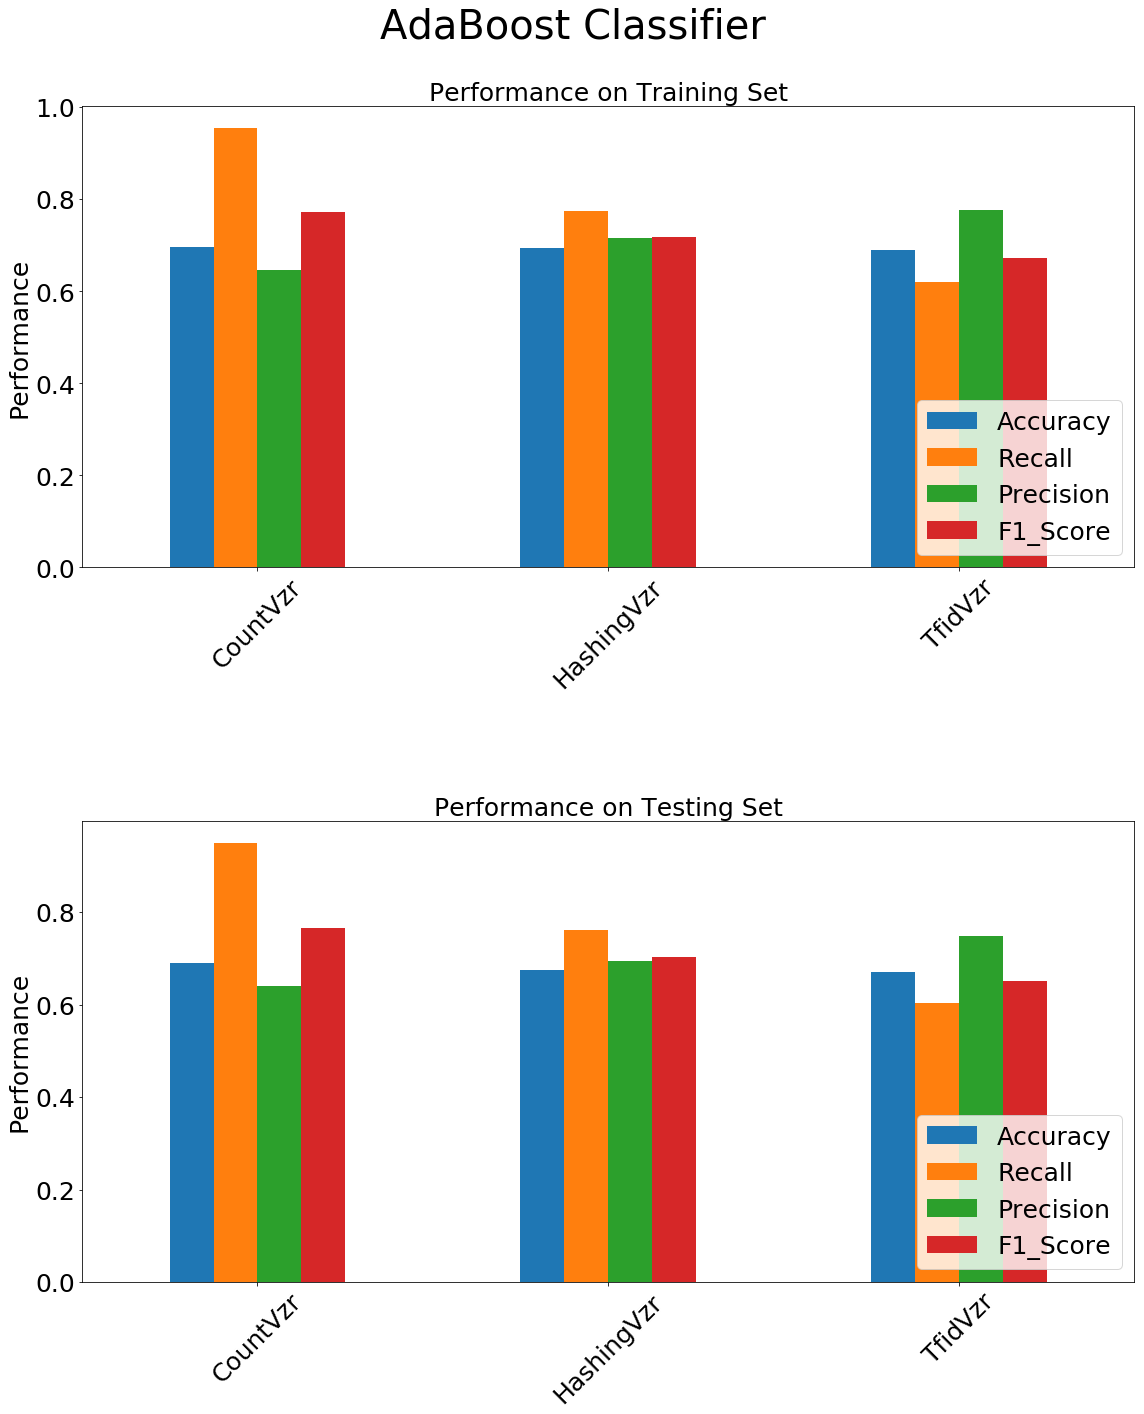

In [82]:
#Feature extraction to loop through
vectorizers = [HashingVectorizer(stop_words='english'), 
               CountVectorizer(stop_words ='english', max_df=0.7),
               TfidfVectorizer(stop_words='english', max_df=0.7)]

#These dictionaries store the averaged values from
#each feature extraction class for later graphing
vzr_train = {"HashingVzr": {},
              "CountVzr": {},
              "TfidVzr": {}}

vzr_tests = {"HashingVzr": {},
              "CountVzr": {},
              "TfidVzr": {}}

#idx for updating the specifc feature extraction
#class scores after each full kfold iteration
idx = 0
for vzr in vectorizers:
    #to store and then average performance scores
    train_scores = []
    tests_scores = []
    

    for train_idx, tests_idx in skf.split(dfrl['claim'], dfrl['signal']):
    
        ######################
        ##Feature extraction##
        ######################
        vectorizer = vzr
        train = vectorizer.fit_transform(dfrl['claim'][train_idx])
        tests = vectorizer.transform(dfrl['claim'][tests_idx])

        #fitting & testing the model
        model = AdaBoostClassifier()
        model.fit(train, dfrl['signal'][train_idx])
        
        #testing fitted model
        predxn_tests = model.predict(tests)
        predxn_train = model.predict(train)


        #evaluation of models & storage of values
        tests_scores.append(get_scores(dfrl['signal'][tests_idx], predxn_tests))
        train_scores.append(get_scores(dfrl['signal'][train_idx], predxn_train))   

    #updates the dictionary of avereaged scores from each vectorizer class  
    vrizer = ["HashingVzr", "CountVzr", "TfidVzr"]
    #training set dictinary update
    vzr_train[vrizer[idx]].update(update_vect_scores(train_scores))
    #testing set dictionary update
    vzr_tests[vrizer[idx]].update(update_vect_scores(tests_scores)) 
    idx += 1

print("Training")
pd.DataFrame.from_dict(vzr_train, orient='index', dtype='float')
print("Testing")
pd.DataFrame.from_dict(vzr_tests, orient='index', dtype='float')

plot_graph(vzr_train, vzr_tests, "AdaBoost Classifier")

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Training


,Accuracy,Recall,Precision,F1_Score
CountVzr,0.946,0.965,0.936,0.951
HashingVzr,0.836,0.872,0.830,0.850
TfidVzr,0.869,0.896,0.864,0.880


Testing


,Accuracy,Recall,Precision,F1_Score
CountVzr,0.726,0.768,0.732,0.749
HashingVzr,0.744,0.784,0.748,0.766
TfidVzr,0.749,0.778,0.757,0.767


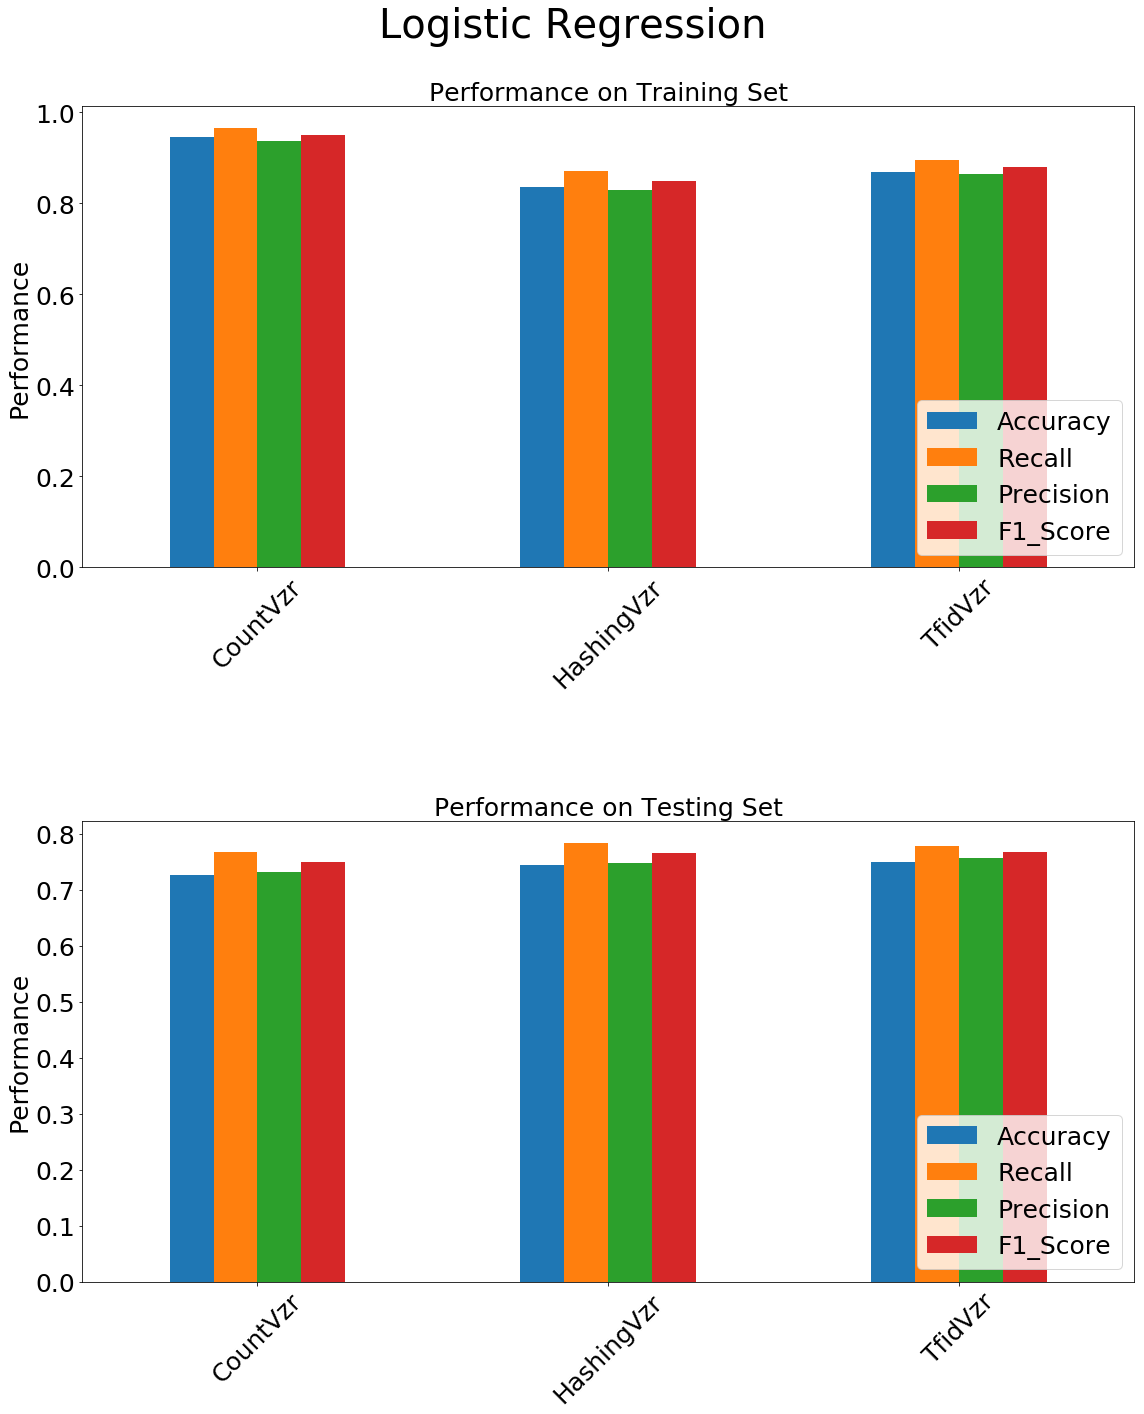

In [83]:
#Feature extraction to loop through
vectorizers = [HashingVectorizer(stop_words='english'), 
               CountVectorizer(stop_words ='english', max_df=0.7),
               TfidfVectorizer(stop_words='english', max_df=0.7)]

#These dictionaries store the averaged values from
#each feature extraction class for later graphing
vzr_train = {"HashingVzr": {},
              "CountVzr": {},
              "TfidVzr": {}}

vzr_tests = {"HashingVzr": {},
              "CountVzr": {},
              "TfidVzr": {}}

#idx for updating the specifc feature extraction
#class scores after each full kfold iteration
idx = 0
for vzr in vectorizers:
    #to store and then average performance scores
    train_scores = []
    tests_scores = []
    

    for train_idx, tests_idx in skf.split(dfrl['claim'], dfrl['signal']):
    
        ######################
        ##Feature extraction##
        ######################
        vectorizer = vzr
        train = vectorizer.fit_transform(dfrl['claim'][train_idx])
        tests = vectorizer.transform(dfrl['claim'][tests_idx])

        #fitting & testing the model
        model = LogisticRegression()
        model.fit(train, dfrl['signal'][train_idx])
        
        #testing fitted model
        predxn_tests = model.predict(tests)
        predxn_train = model.predict(train)


        #evaluation of models & storage of values
        tests_scores.append(get_scores(dfrl['signal'][tests_idx], predxn_tests))
        train_scores.append(get_scores(dfrl['signal'][train_idx], predxn_train))   

    #updates the dictionary of avereaged scores from each vectorizer class  
    vrizer = ["HashingVzr", "CountVzr", "TfidVzr"]
    #training set dictinary update
    vzr_train[vrizer[idx]].update(update_vect_scores(train_scores))
    #testing set dictionary update
    vzr_tests[vrizer[idx]].update(update_vect_scores(tests_scores)) 
    idx += 1

print("Training")
pd.DataFrame.from_dict(vzr_train, orient='index', dtype='float')
print("Testing")
pd.DataFrame.from_dict(vzr_tests, orient='index', dtype='float')

plot_graph(vzr_train, vzr_tests, "Logistic Regression")